In [2]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import pandas as pd # Pandas
import uproot
import pickle
import logging
import pprint

import os # read directories etc.
# from scipy.signal import find_p


# import time
# from timeout_decorator import timeout

from LoadBatch import *
from SensorClasses import *

debug = False
verbose = False

In [3]:
logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] -\t %(message)s')

In [19]:
PIXEL_SIZE = 0.0185 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
### I should just have many options for ranges and choose between those
large_bins = (np.arange(0, 900,1),
              np.arange(0, 900,1))

bins1 = (np.arange(450, 700, 1),
        np.arange(150, 450, 1))

bins2 = (np.arange(500, 650, 1),
              np.arange(200, 450, 1))

### Load the dictionary of sensor names and runs
sensors_list = read_pickle("sensors_list.pickle")  ### I still need the sensor_list for now
dict_of_runs = read_pickle("dict_of_runs.pickle")
dict_of_batches = read_pickle("dict_of_batches.pickle")

if verbose: 
    pprint.pprint(dict_of_runs)
    pprint.pprint(dict_of_batches)

### branches to be loaded (+ unnecessary columns)
branches = ["eventNumber", "Xtr", "Ytr", "pulseHeight", "charge", "timeCFD20", "timeCFD50", "timeCFD70"]
columns_to_remove = ["Xtr_4","Xtr_5","Xtr_6","Xtr_7","Ytr_4","Ytr_5","Ytr_6","Ytr_7"]

{'S1': {100: [9564, 9565, 9567, 9568, 9570],
        101: [9574],
        199: [9577, 9578, 9579, 9580, 9581],
        201: [9587, 9588, 9590],
        202: [9591, 9592, 9593, 9594],
        203: [9595, 9596, 9602],
        204: [9672, 9673, 9674],
        205: [9742, 9743, 9744, 9745],
        206: [9746, 9747, 9748, 9750],
        301: [9609, 9611, 9613, 9614, 9615, 9616],
        401: [9620, 9621, 9622, 9624, 9625, 9627, 9628, 9629, 9630],
        402: [9631, 9632, 9633, 9636, 9637, 9638, 9639],
        403: [9640, 9642, 9644, 9645, 9646],
        406: [9677, 9678, 9679, 9680, 9694],
        407: [9683, 9684, 9685, 9686, 9687, 9688, 9689, 9691, 9692, 9693],
        408: [9695, 9696, 9698],
        409: [9701, 9702, 9703],
        410: [9704, 9705],
        411: [9721, 9722],
        413: [9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9775],
        414: [9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786],
        501: [9796, 9797, 9798, 9799, 9800, 9801, 9802, 9803,

In [20]:
unique_names = []
for batch_object in dict_of_batches.values():
    for S in ['S1','S2']:
        for ch, sensor in batch_object.S[S].channels.items():
            if (sensor.name != '') and (sensor.name not in unique_names):
                unique_names.append(sensor.name)
if verbose: print(unique_names)

for name in unique_names:
    for batch_object in dict_of_batches.values():
        for S in ['S1','S2']:  
                for ch, sensor in batch_object.S[S].channels.items():
                    if (sensor.name == name):
                        print(f"{sensor.name}, board: {sensor.board}\tV: {sensor.voltage}, angle: {batch_object.angle}°,", "temp: %.2f°C,"%batch_object.tempA, f"fluence: {sensor.fluence}, in batch {batch_object.batch_number}, {S}, {ch})")
    print('-'*100)

['MCP', 'IMEv3-W12-C2-2-2', 'IMEv3-W12-C3-1-4', 'CNM-R15973-W5-D138', 'CNM-R15973-W4-D168', 'IMEv3-W12-C3-1-5', 'USTC2.1-W17-P6-A', 'JSI-PP4-IMEv2-W7-6.5E14', 'JSI-B7-IMEv3-W16-8E14', 'JSI-B13-IMEv3-W16-2.5E15', 'JSI-B6-IMEv2-W7-1E14', 'JSI-PP1', 'CERN2-CH0-IMEv3-W12', 'CERN2-CH1-IMEv3-W12', 'CERN2-CH2-IMEv3-W12', 'JSI-B5-CNM-W3-2.5E15', 'CERN2-CH4-IMEv3-W16', 'JSI-B2-USTC-V2.1-W17-2E14']
MCP, board:  	V: 2600, angle: 0.0°, temp: -31.02°C, fluence: 0, in batch 199, S1, Ch1)
MCP, board:  	V: 2600, angle: 0.0°, temp: -31.02°C, fluence: 0, in batch 199, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.84°C, fluence: 0, in batch 100, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -32.84°C, fluence: 0, in batch 100, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -33.30°C, fluence: 0, in batch 101, S1, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -33.30°C, fluence: 0, in batch 101, S2, Ch1)
MCP, board:  	V: 2500, angle: 0.0°, temp: -31.33°C, fluence: 0, in batch 201, S1, Ch1)

In [21]:
# this_batch = 603
# this_scope = 'S1'

# for ch, sensor in dict_of_batches[this_batch].S[this_scope].channels.items():
#     print(f"{this_scope}, {ch}:", sensor.__dict__)

In [22]:
# df = load_batch(this_batch, this_scope)


## USTC
looking specifically at one sensor

In [23]:
USTC_list = []
USTC_dict = {'room_temp':[], 'angled':[]} # 
### maybe I can make all this weird iterations into a function
for batch_object in dict_of_batches.values():
    for S in ['S1','S2']:
        for ch, sensor in batch_object.S[S].channels.items():
            if 'USTC' in sensor.name:
                USTC_list.append((batch_object.batch_number, S, ch))
                if batch_object.tempA>0:
                    USTC_dict['room_temp'].append((batch_object.batch_number, S, ch))
                if batch_object.angle>0:
                    USTC_dict['angled'].append((batch_object.batch_number, S, ch))

if verbose: pprint.pprint(USTC_list)

[(301, 'S1', 'Ch2'),
 (301, 'S1', 'Ch3'),
 (401, 'S1', 'Ch2'),
 (401, 'S1', 'Ch3'),
 (402, 'S1', 'Ch2'),
 (402, 'S1', 'Ch3'),
 (403, 'S1', 'Ch2'),
 (403, 'S1', 'Ch3'),
 (406, 'S1', 'Ch2'),
 (406, 'S1', 'Ch3'),
 (407, 'S1', 'Ch2'),
 (407, 'S1', 'Ch3'),
 (408, 'S1', 'Ch2'),
 (408, 'S1', 'Ch3'),
 (409, 'S1', 'Ch2'),
 (409, 'S1', 'Ch3'),
 (410, 'S1', 'Ch2'),
 (410, 'S1', 'Ch3'),
 (411, 'S1', 'Ch2'),
 (411, 'S1', 'Ch3'),
 (412, 'S1', 'Ch2'),
 (412, 'S1', 'Ch3'),
 (413, 'S1', 'Ch2'),
 (413, 'S1', 'Ch3'),
 (414, 'S1', 'Ch2'),
 (414, 'S1', 'Ch3'),
 (1301, 'S2', 'Ch3'),
 (1302, 'S2', 'Ch3'),
 (1303, 'S2', 'Ch3'),
 (1304, 'S2', 'Ch3'),
 (1305, 'S2', 'Ch3'),
 (1306, 'S2', 'Ch3')]


In [24]:
verbose = True

In [25]:
# this_scope = 'S1'
DUTs = [1,2]
### Oscilloscope 1, Channels 2 and 3
print('Room temperature')
for batch_number,S,ch in USTC_dict['room_temp']:
    if verbose:
        print('Batch', batch_number, 'MCP voltage:', dict_of_batches[batch_number].S[S].channels['Ch1'].voltage)
        print('sensor:',dict_of_batches[batch_number].S[S].channels[ch].__dict__)
    else: pass

batches_to_study = [(301,'S1'),(408,'S1'),(409,'S1')]  ### with MPC at 2500


Room temperature
Batch 301 MCP voltage: 2500
sensor: {'name': 'USTC2.1-W17-P6-A', 'angle': 0, 'board': 'CERN-3', 'dut_position': 3.0, 'fluence': 0, 'transimpedance': 10700, 'voltage': -120}
Batch 301 MCP voltage: 2500
sensor: {'name': 'USTC2.1-W17-P6-A', 'angle': 0, 'board': 'CERN-3', 'dut_position': 3.0, 'fluence': 0, 'transimpedance': 10700, 'voltage': -120}
Batch 408 MCP voltage: 2500
sensor: {'name': 'USTC2.1-W17-P6-A', 'angle': 0, 'board': 'CERN-3', 'dut_position': 3.0, 'fluence': 0, 'transimpedance': 10700, 'voltage': -150}
Batch 408 MCP voltage: 2500
sensor: {'name': 'USTC2.1-W17-P6-A', 'angle': 0, 'board': 'CERN-3', 'dut_position': 3.0, 'fluence': 0, 'transimpedance': 10700, 'voltage': -150}
Batch 409 MCP voltage: 2500
sensor: {'name': 'USTC2.1-W17-P6-A', 'angle': 0, 'board': 'CERN-3', 'dut_position': 3.0, 'fluence': 0, 'transimpedance': 10700, 'voltage': -165}
Batch 409 MCP voltage: 2500
sensor: {'name': 'USTC2.1-W17-P6-A', 'angle': 0, 'board': 'CERN-3', 'dut_position': 3.0, '

[WARNING] -	 in time_mask() plot has been closed
[WARNING] -	 in time_mask() plot has been closed


DUT_1
DUT_2


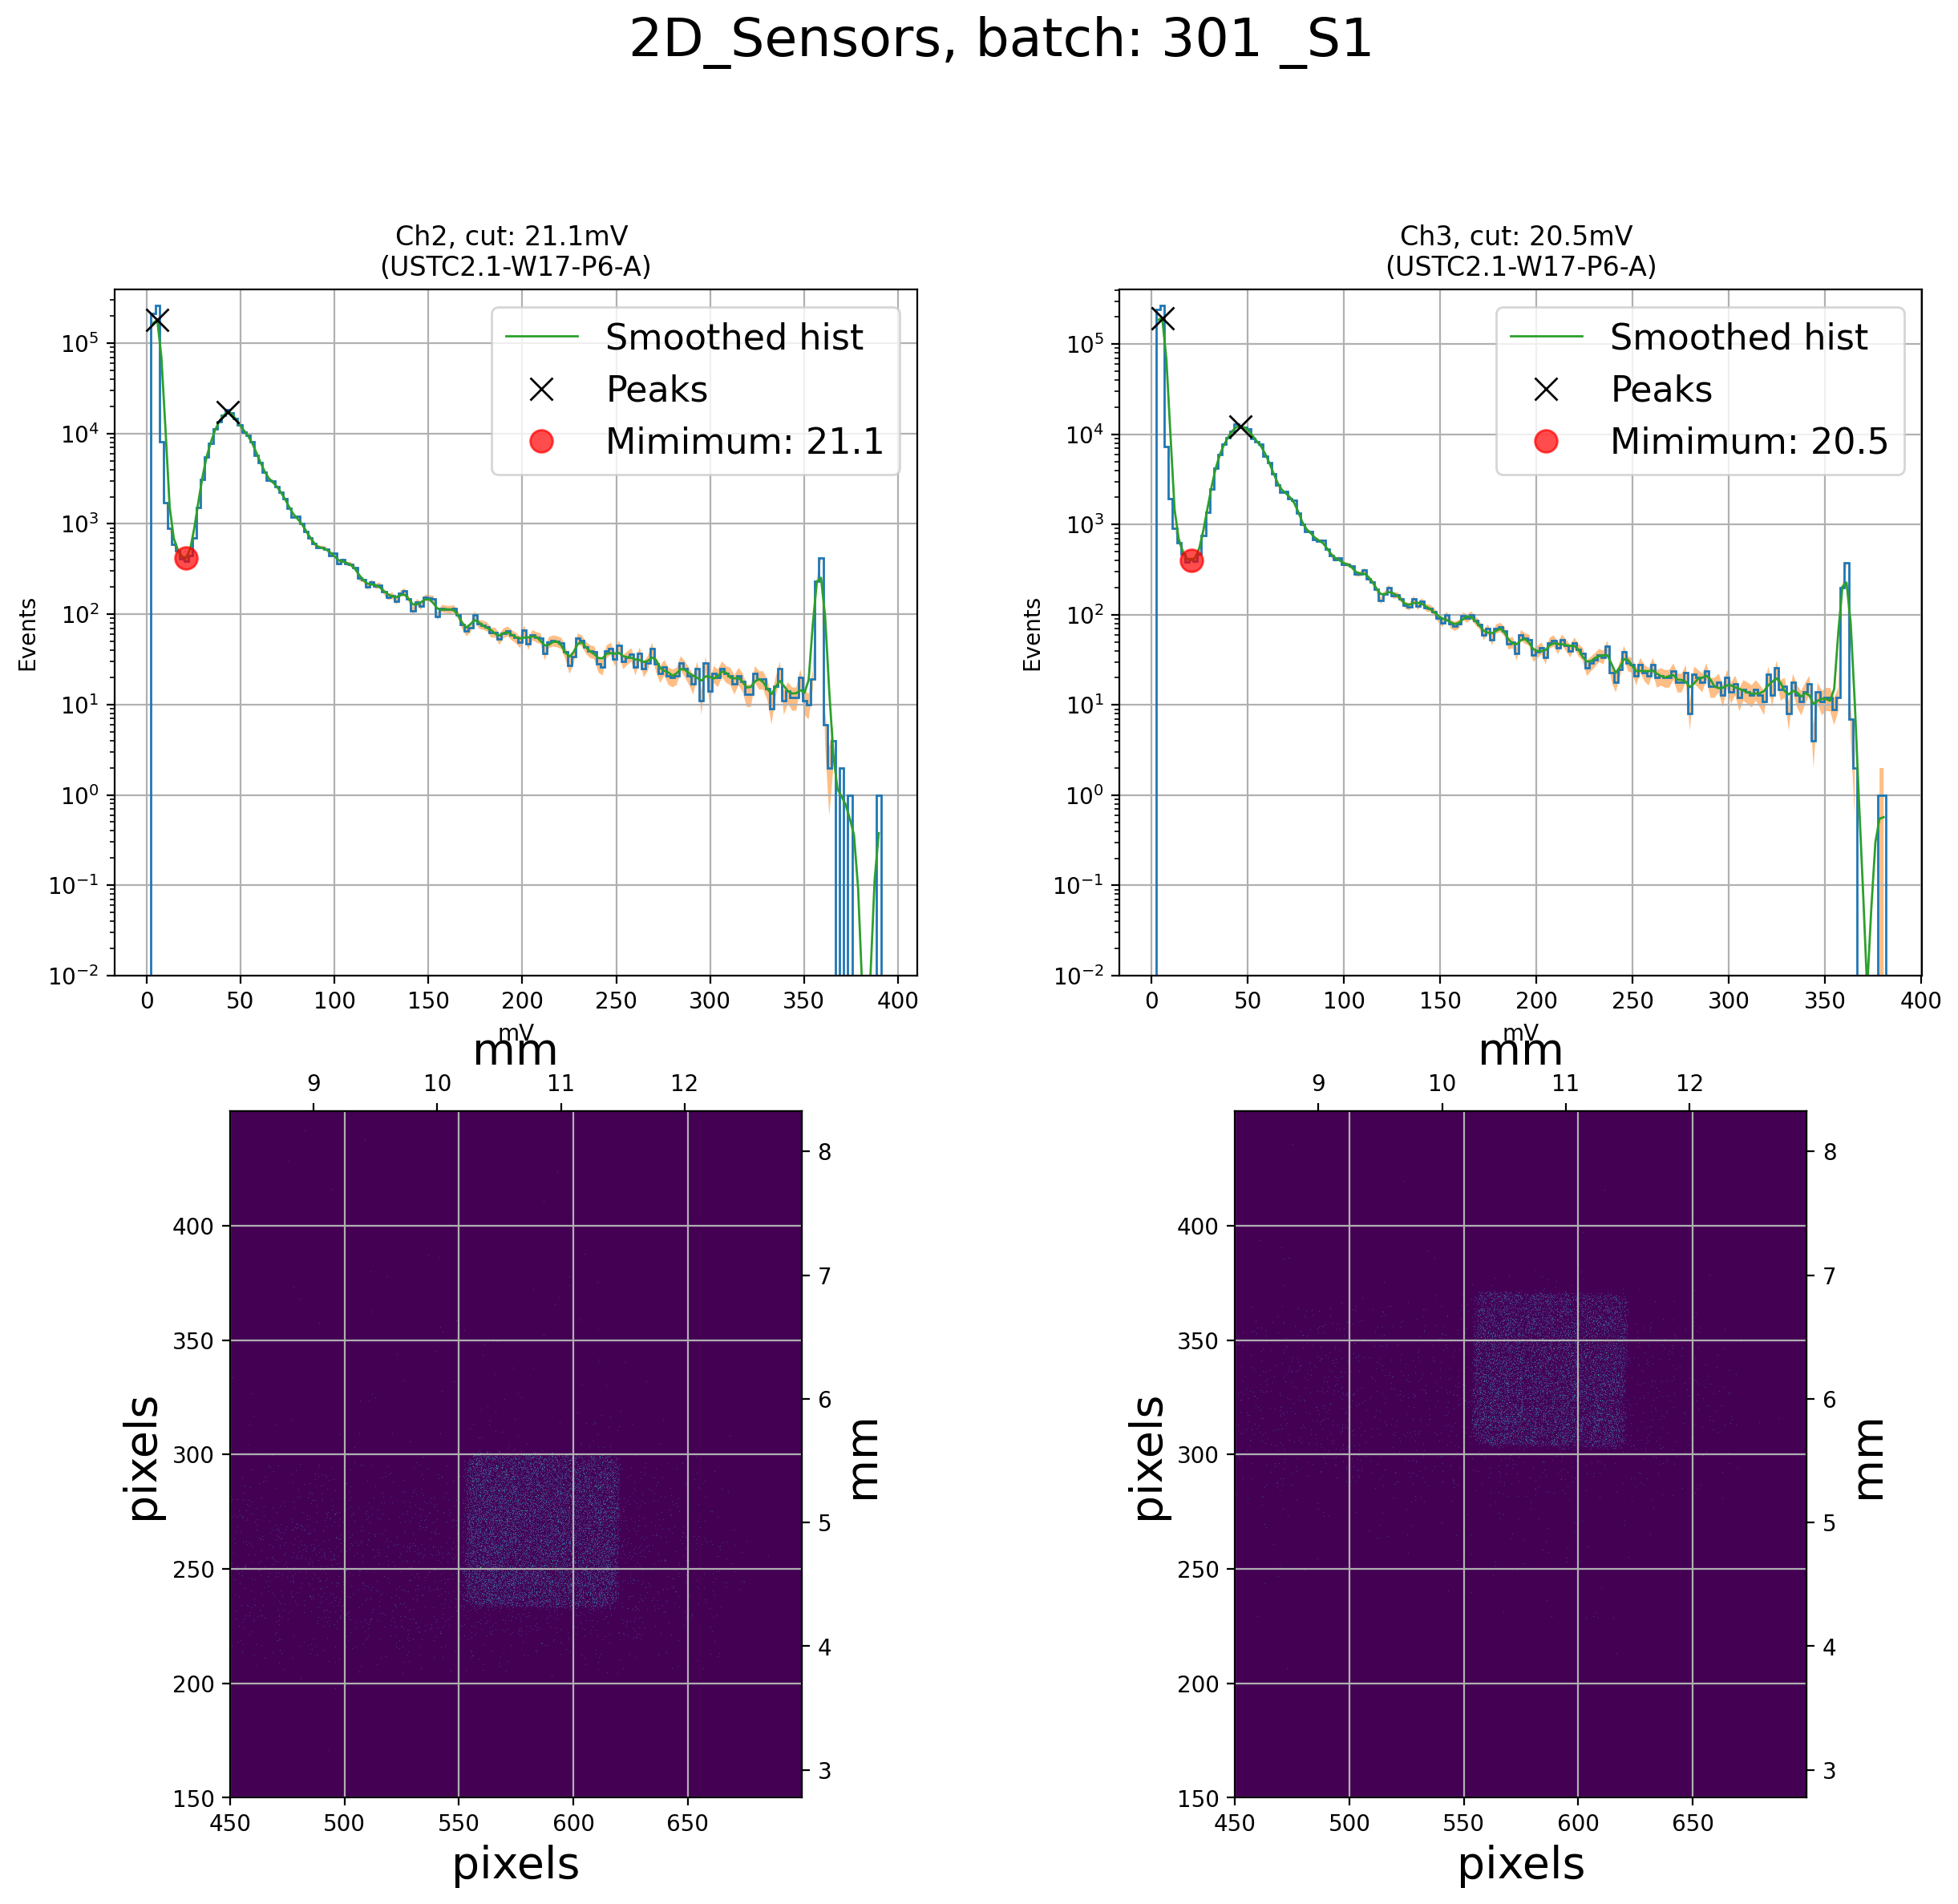

[WARNING] -	 in find_min_btw_peaks(), closing plots
[WARNING] -	 in find_min_btw_peaks(), closing plots


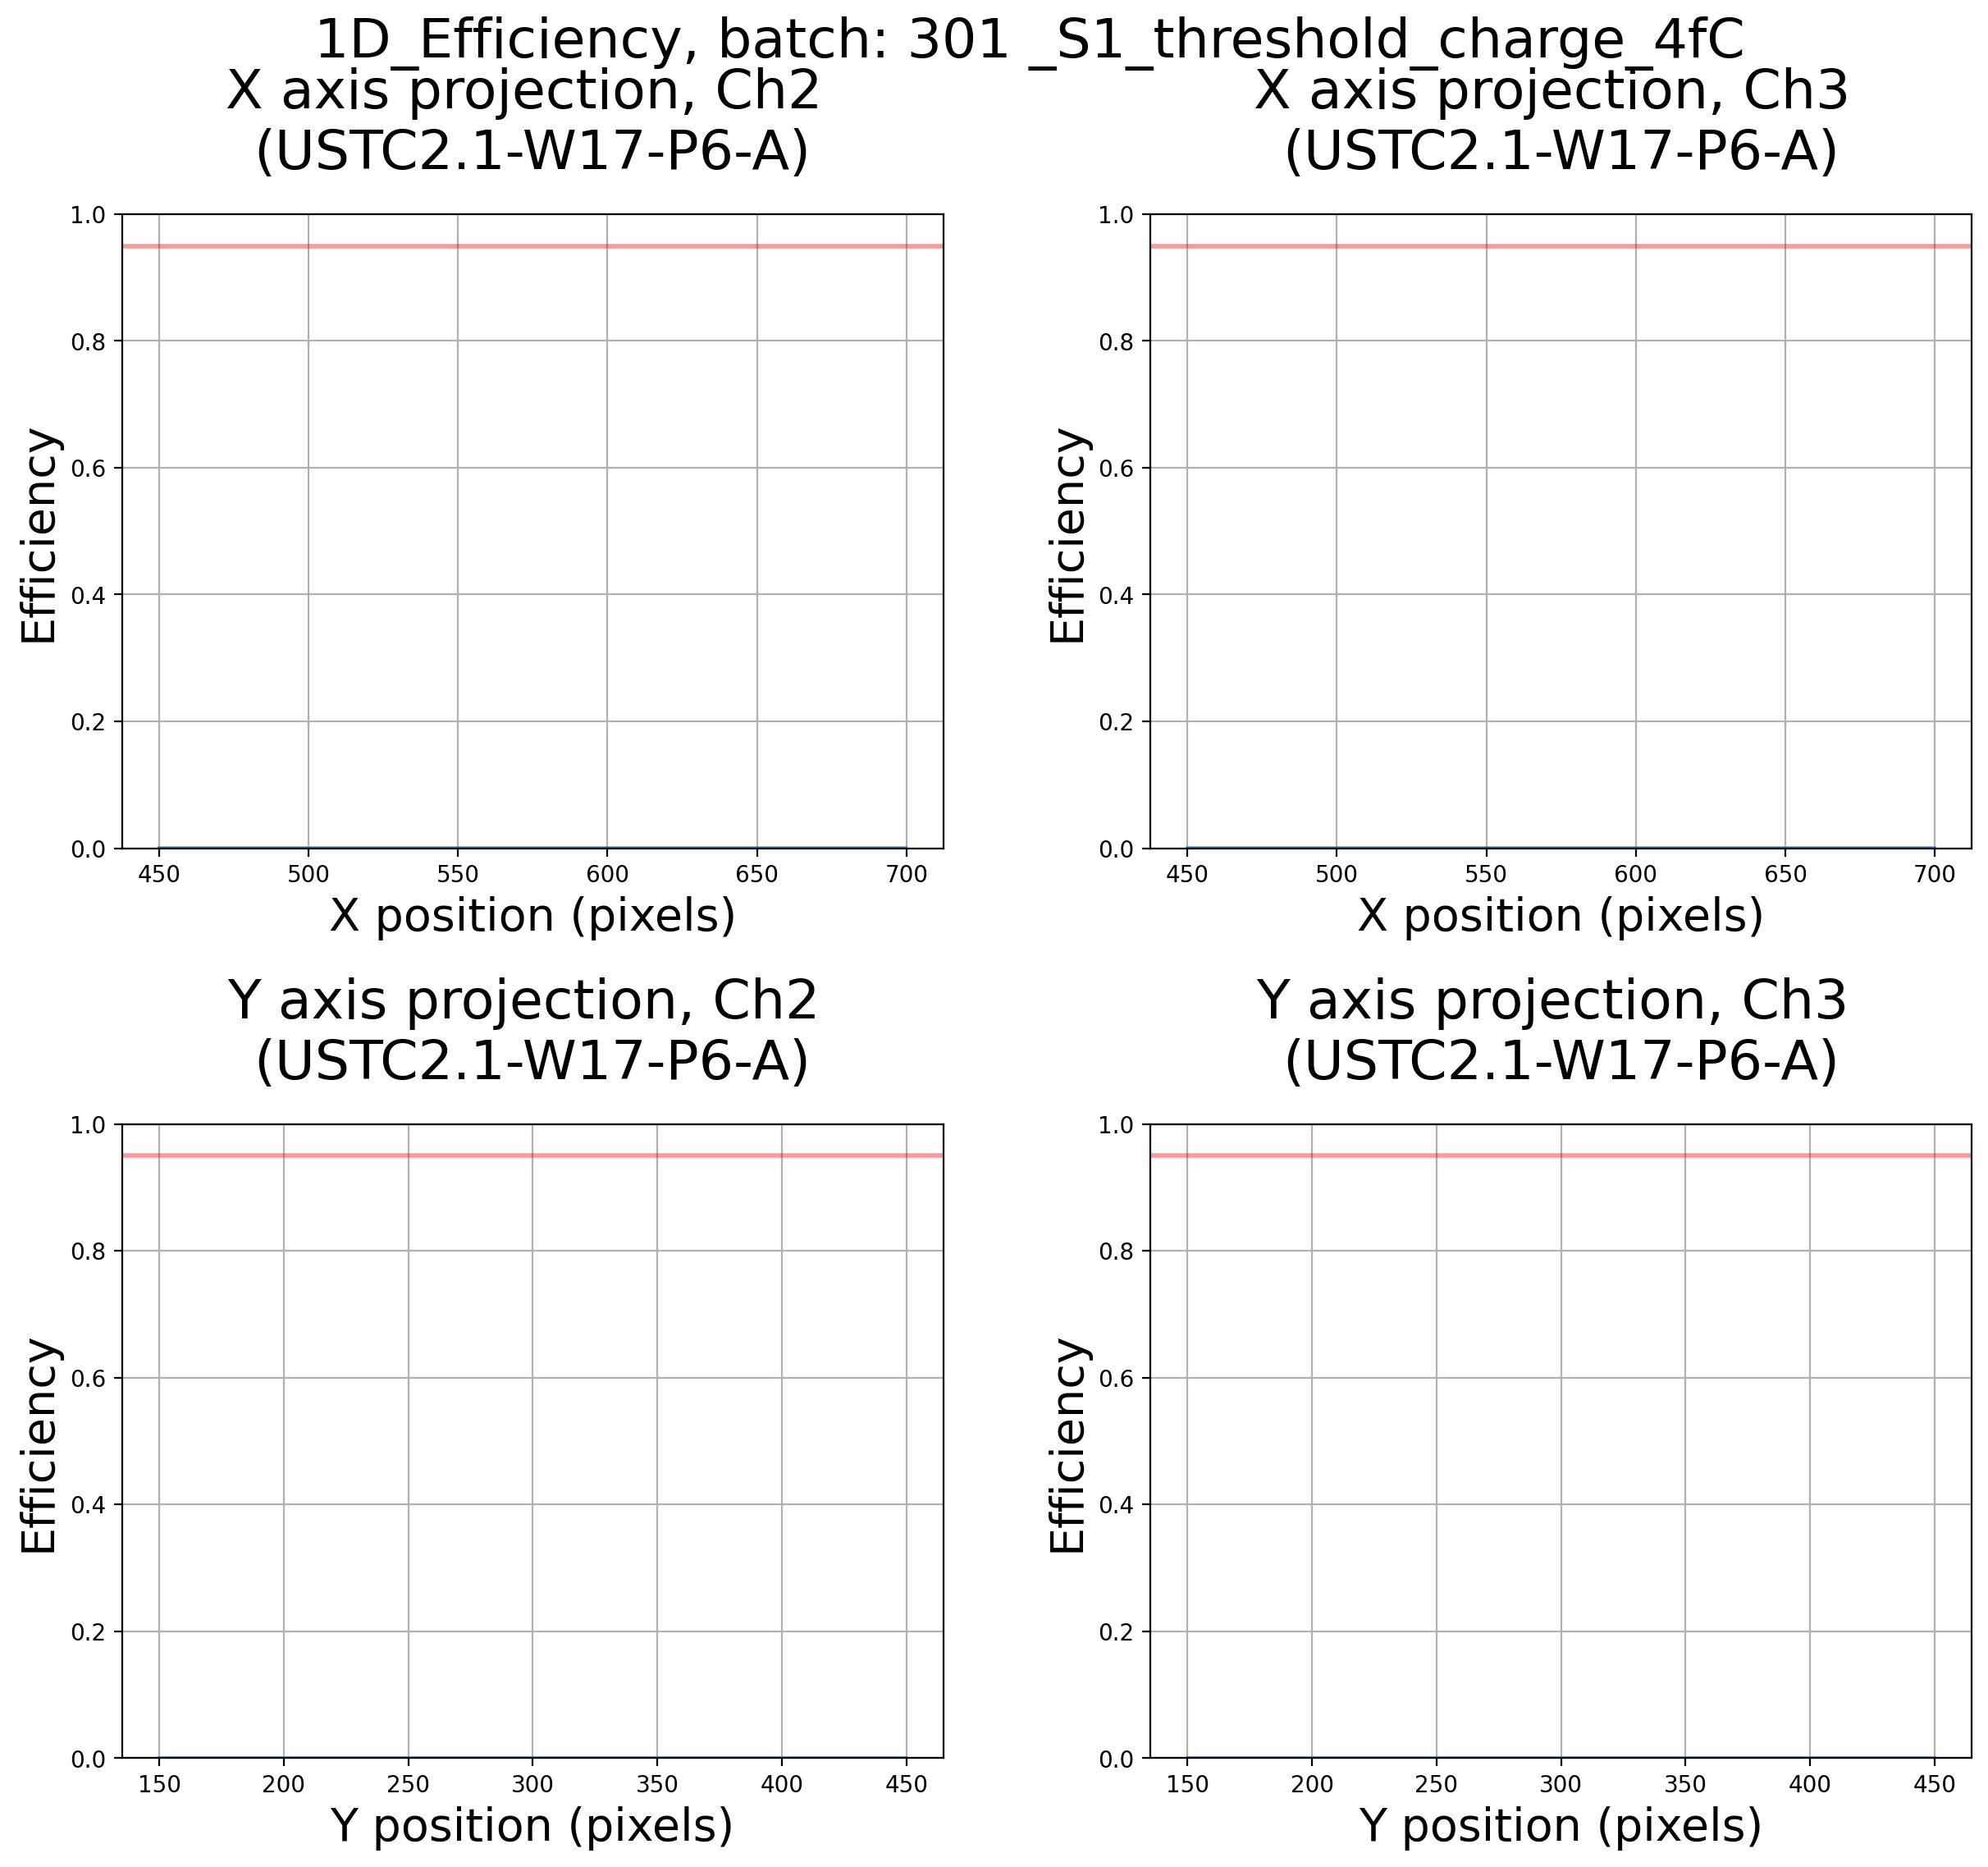

[WARNING] -	 in find_min_btw_peaks(), closing plots
[WARNING] -	 in find_min_btw_peaks(), closing plots


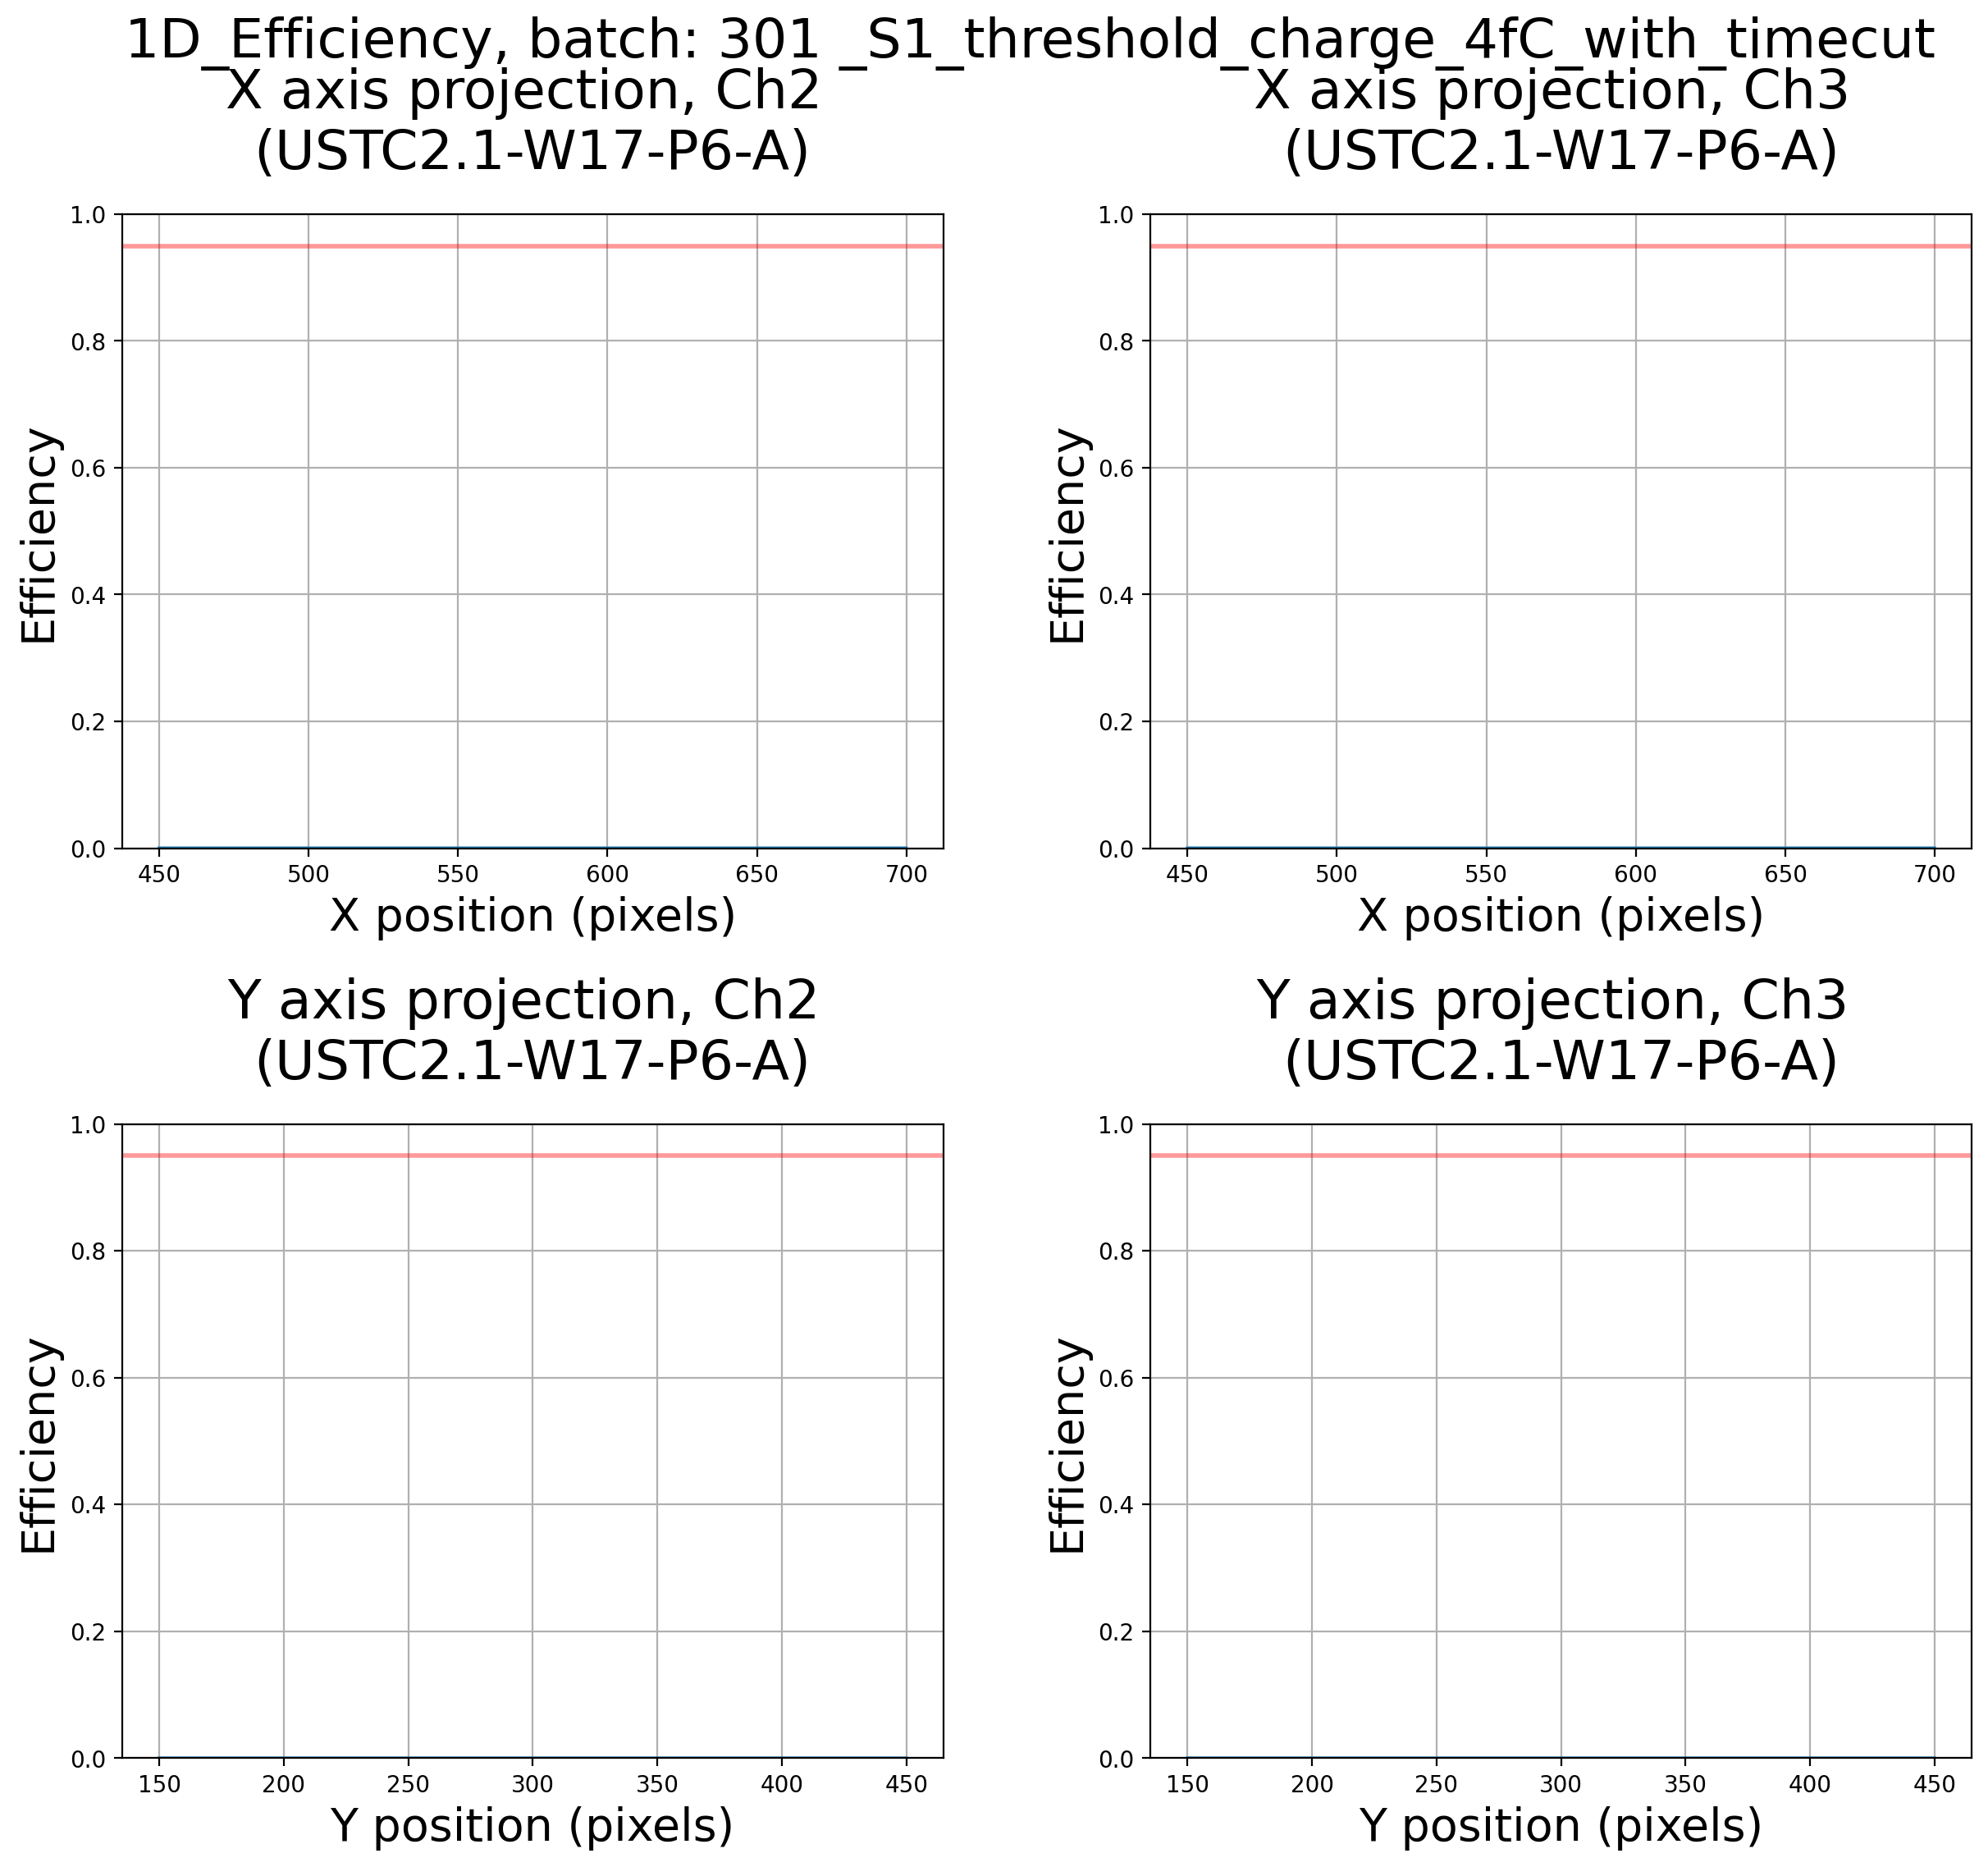

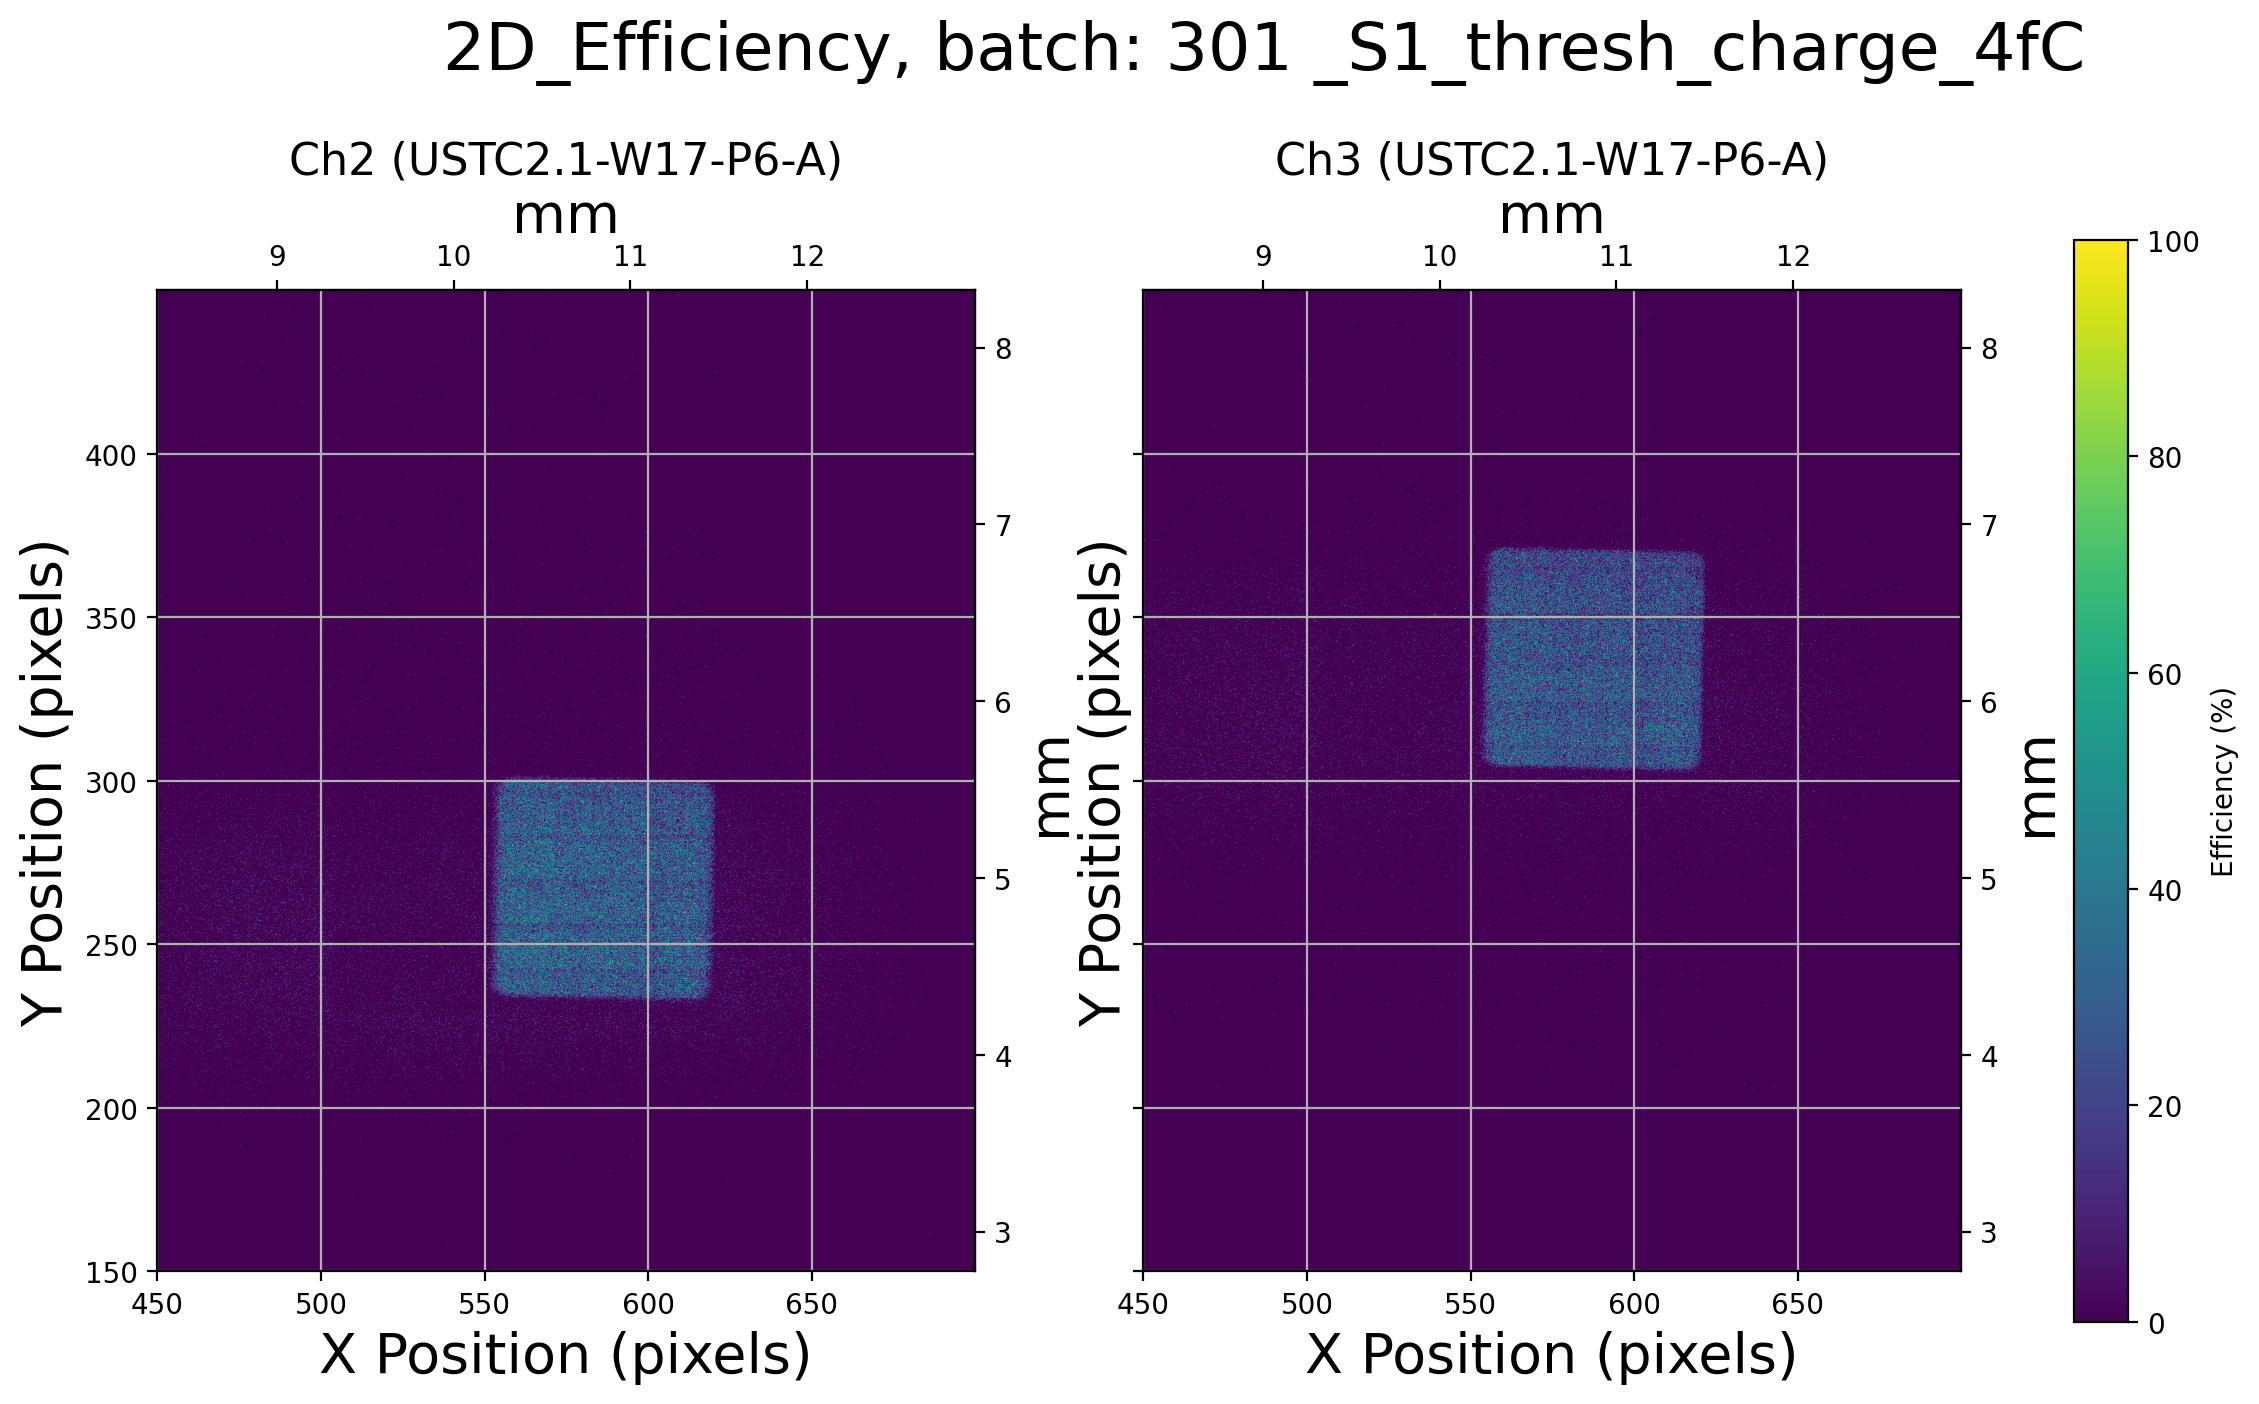

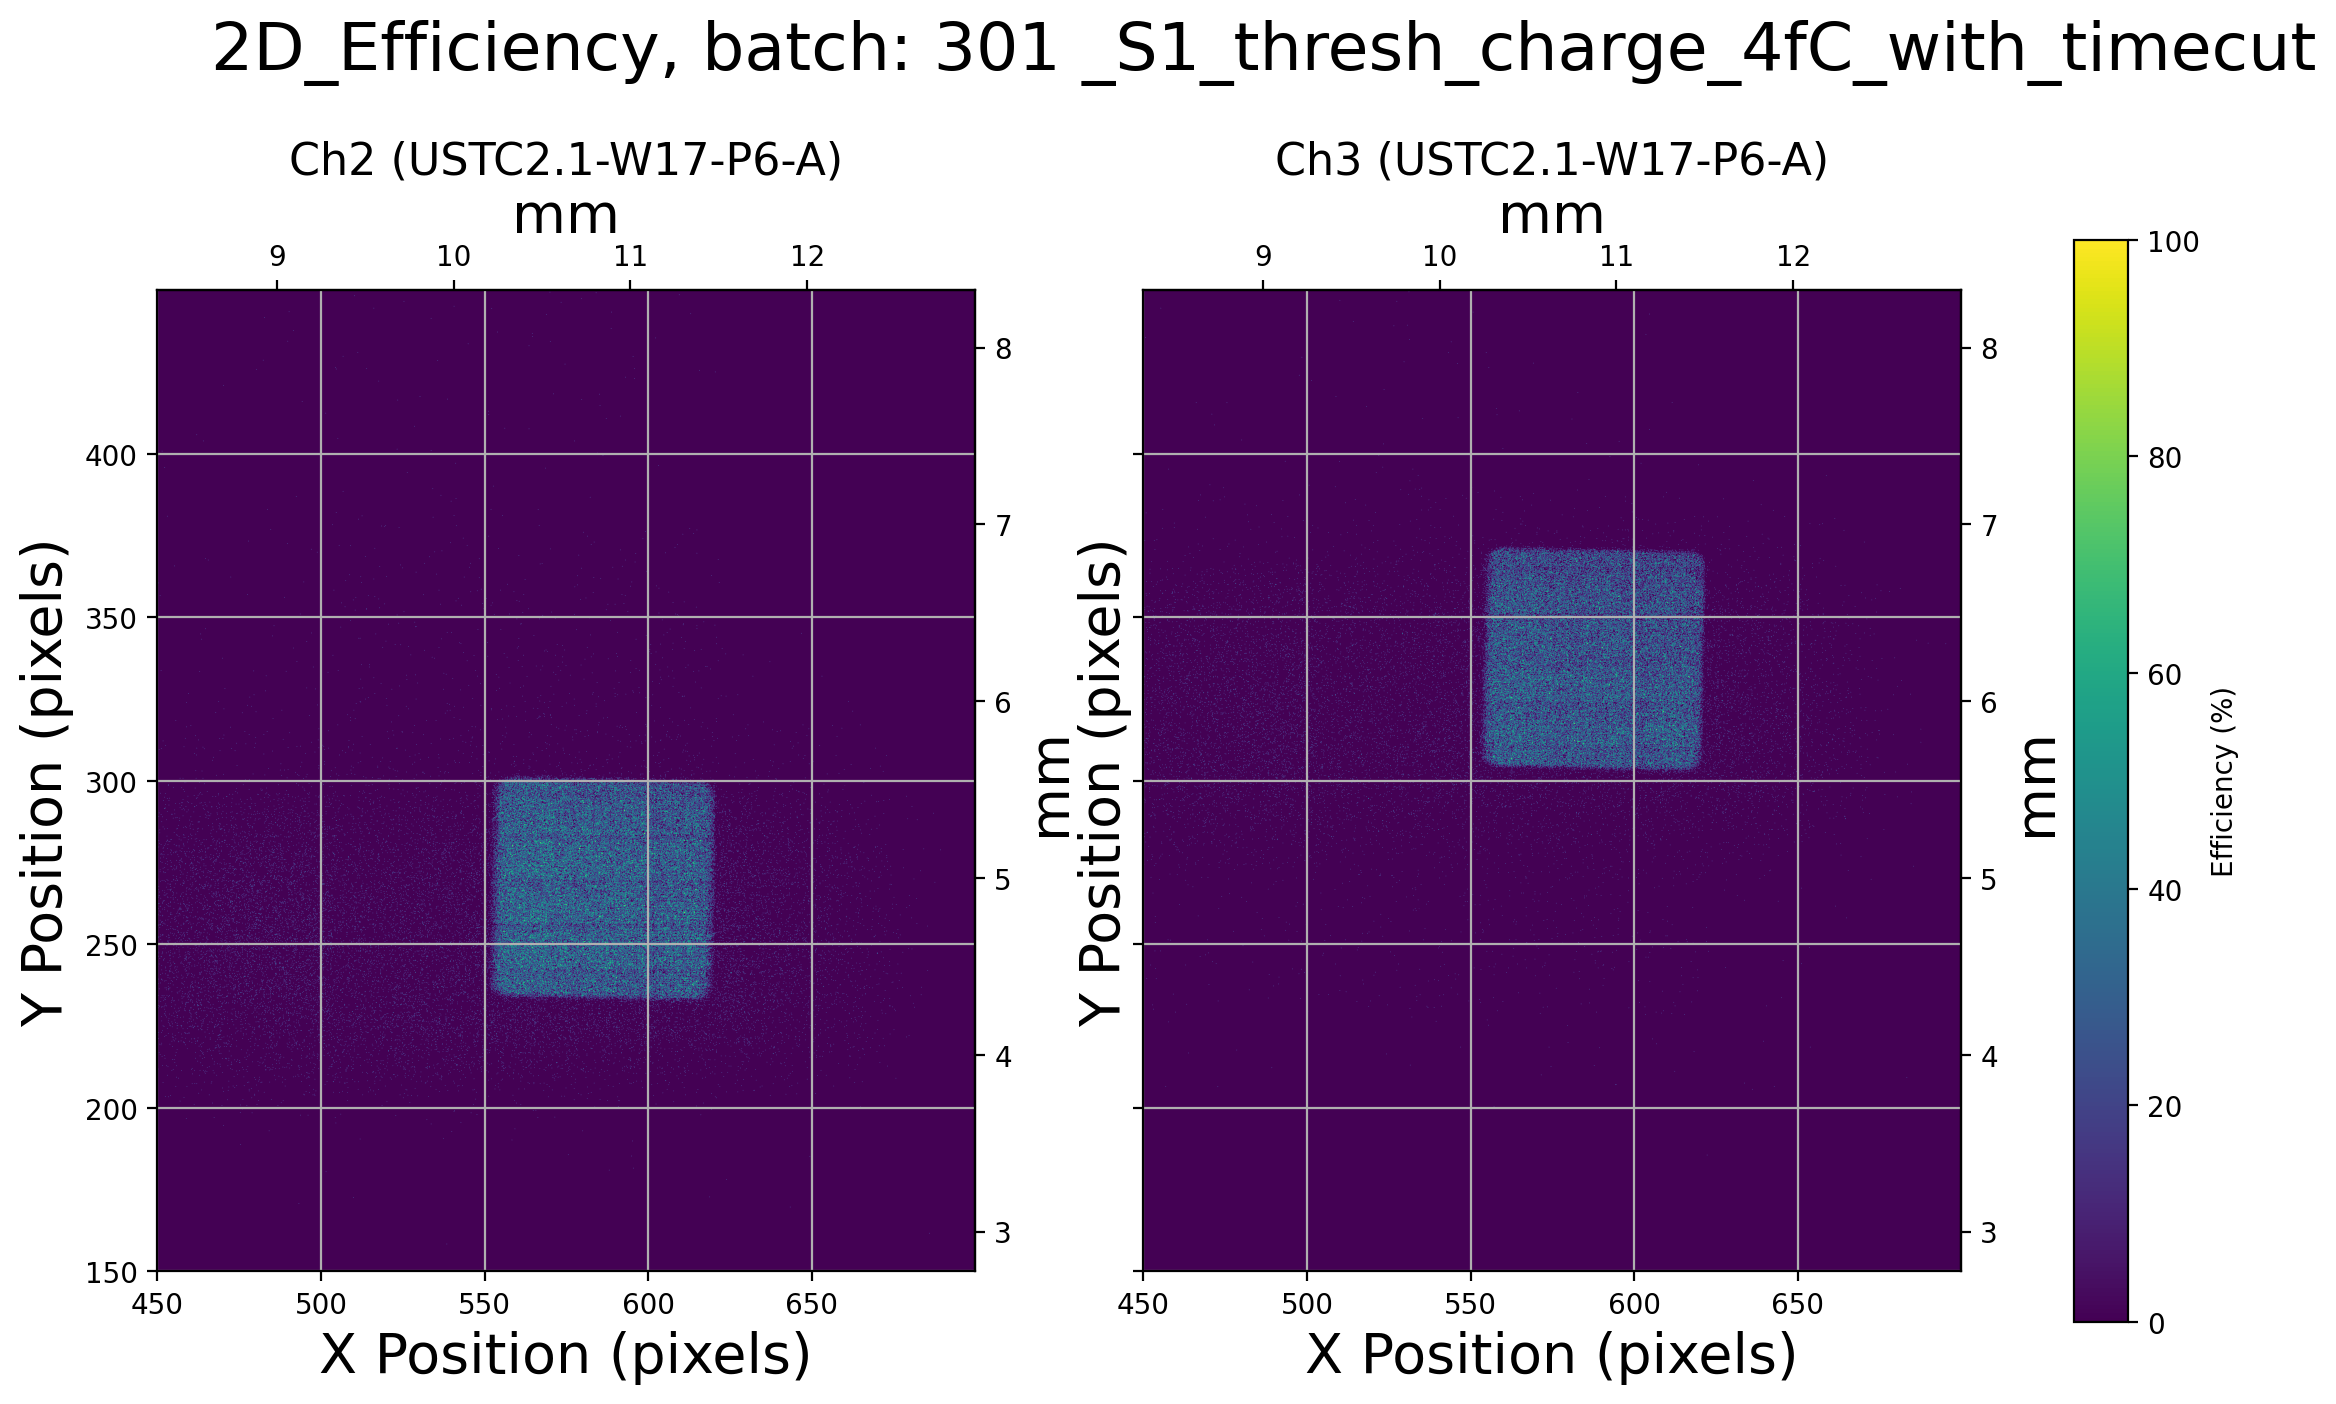

[WARNING] -	 in time_mask() plot has been closed
[WARNING] -	 in time_mask() plot has been closed


DUT_1
DUT_2


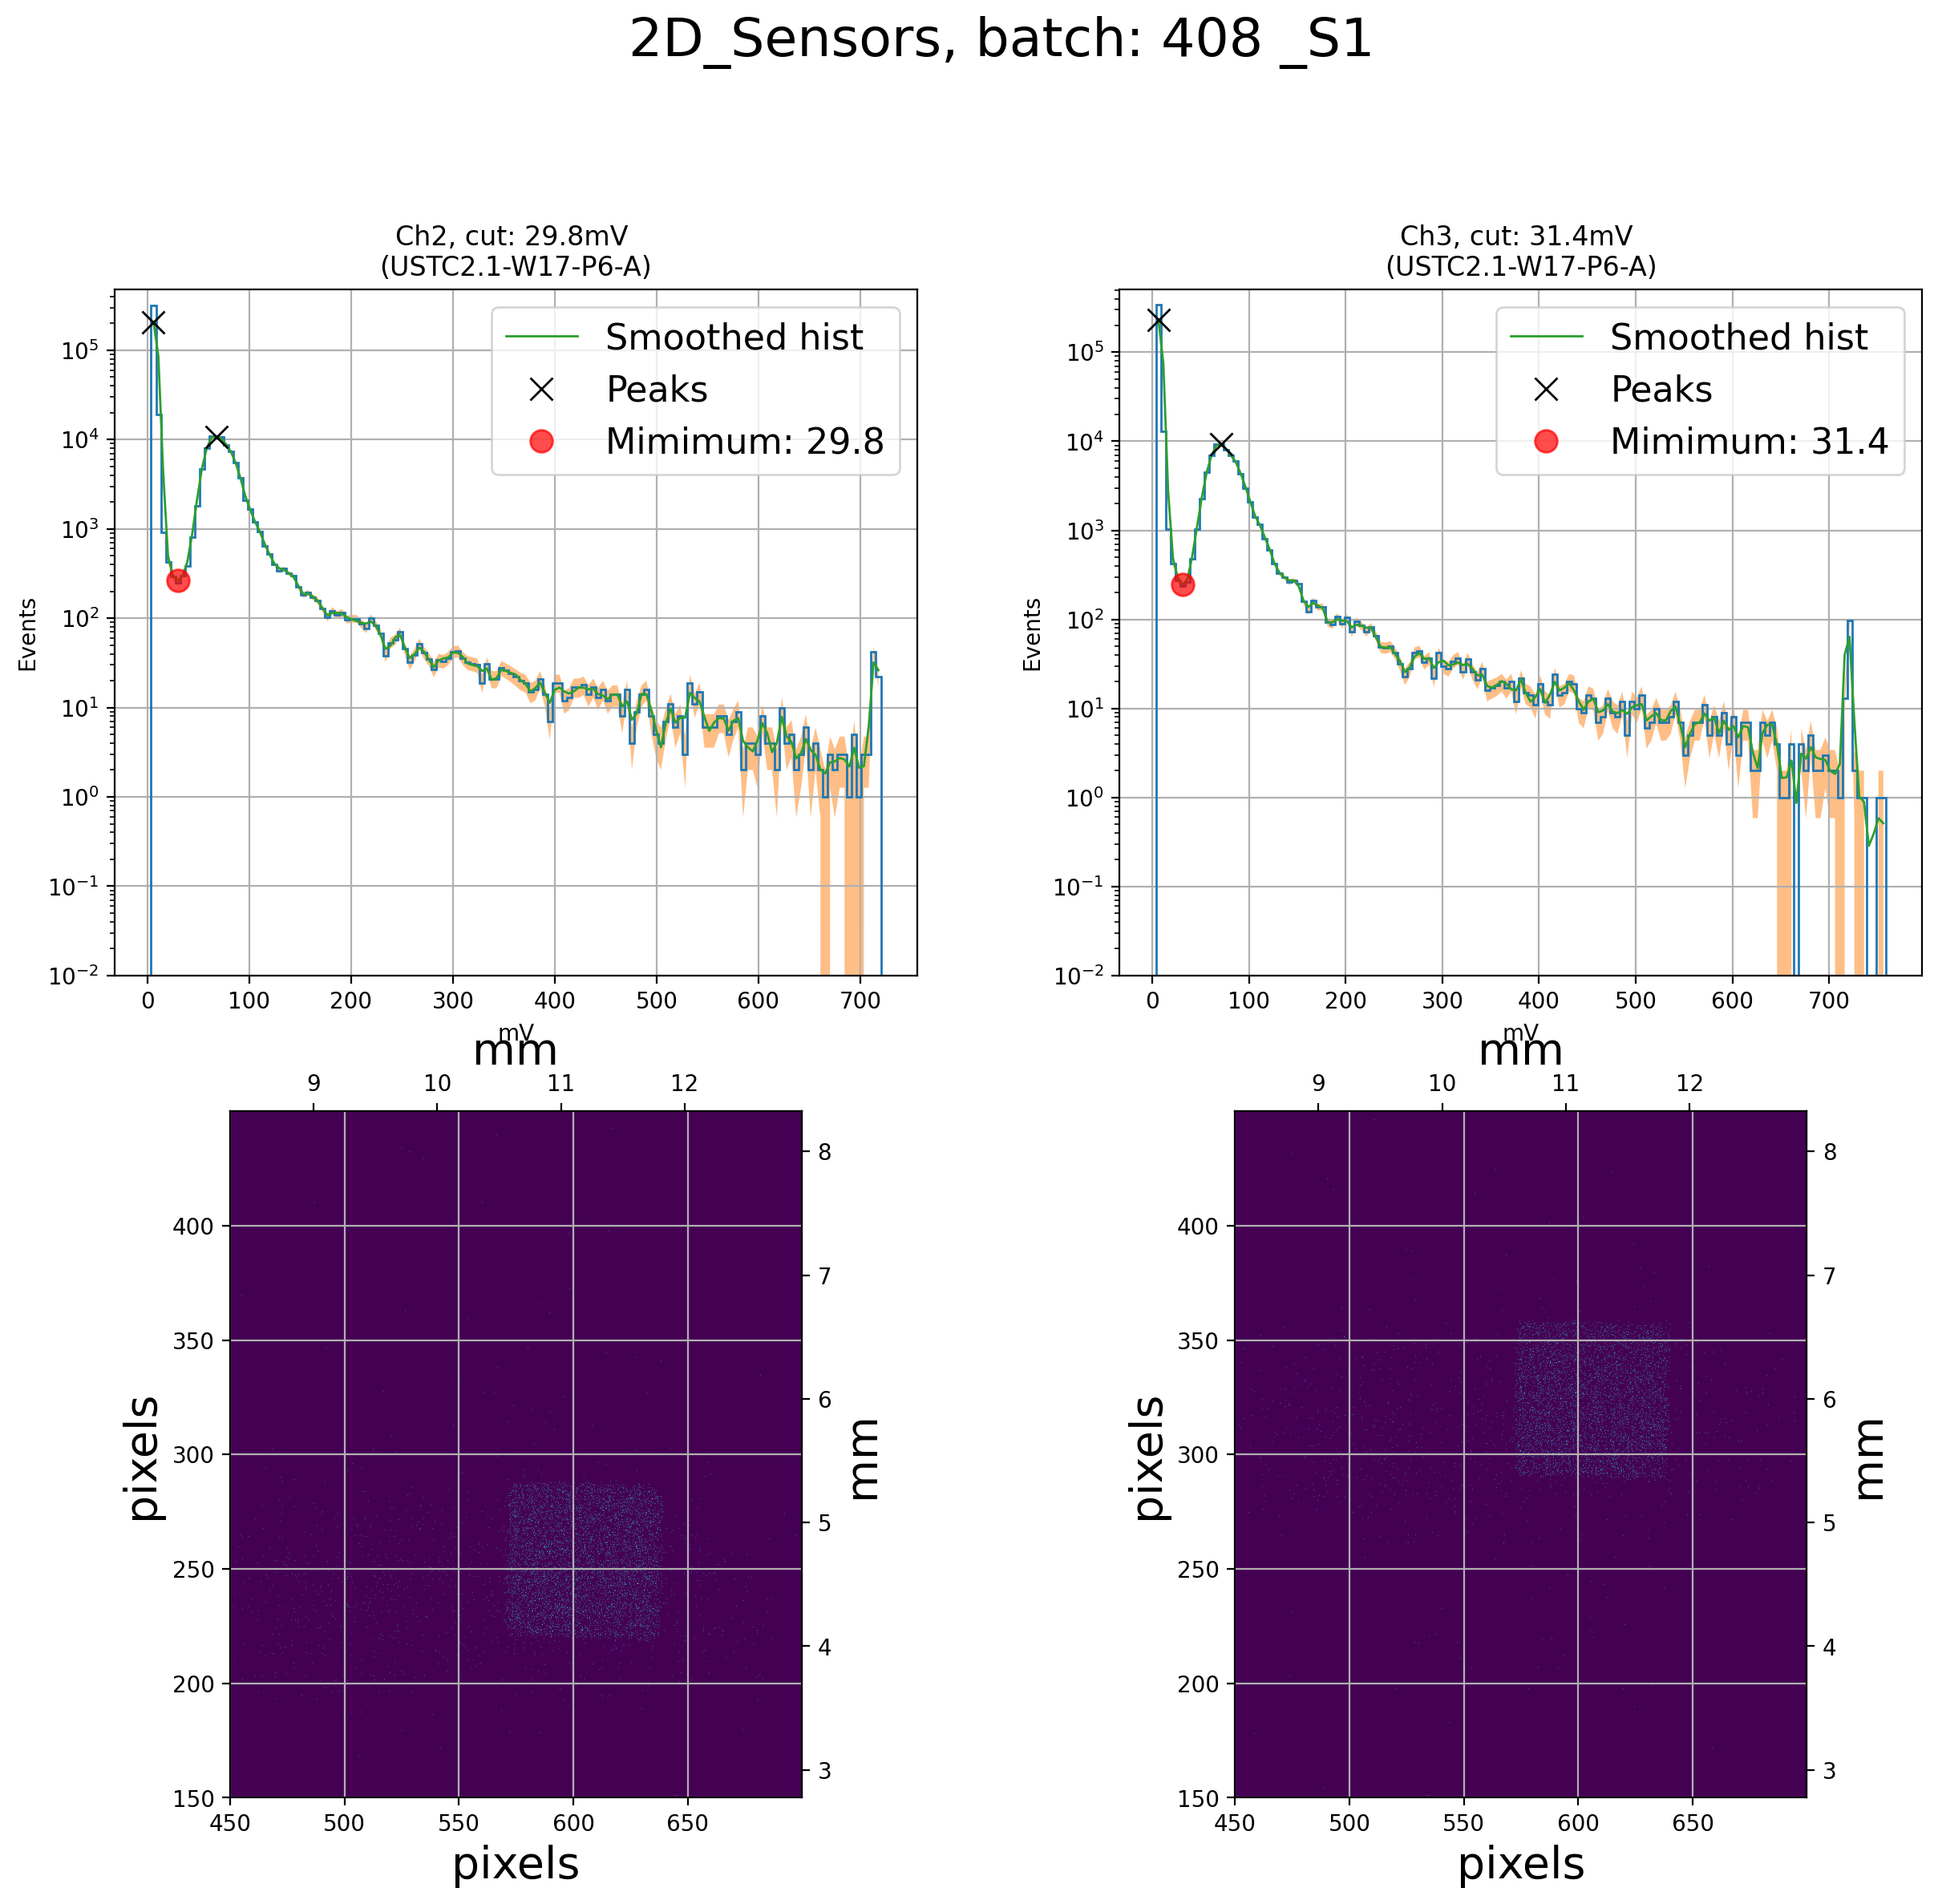

[WARNING] -	 in find_min_btw_peaks(), closing plots
[WARNING] -	 in find_min_btw_peaks(), closing plots


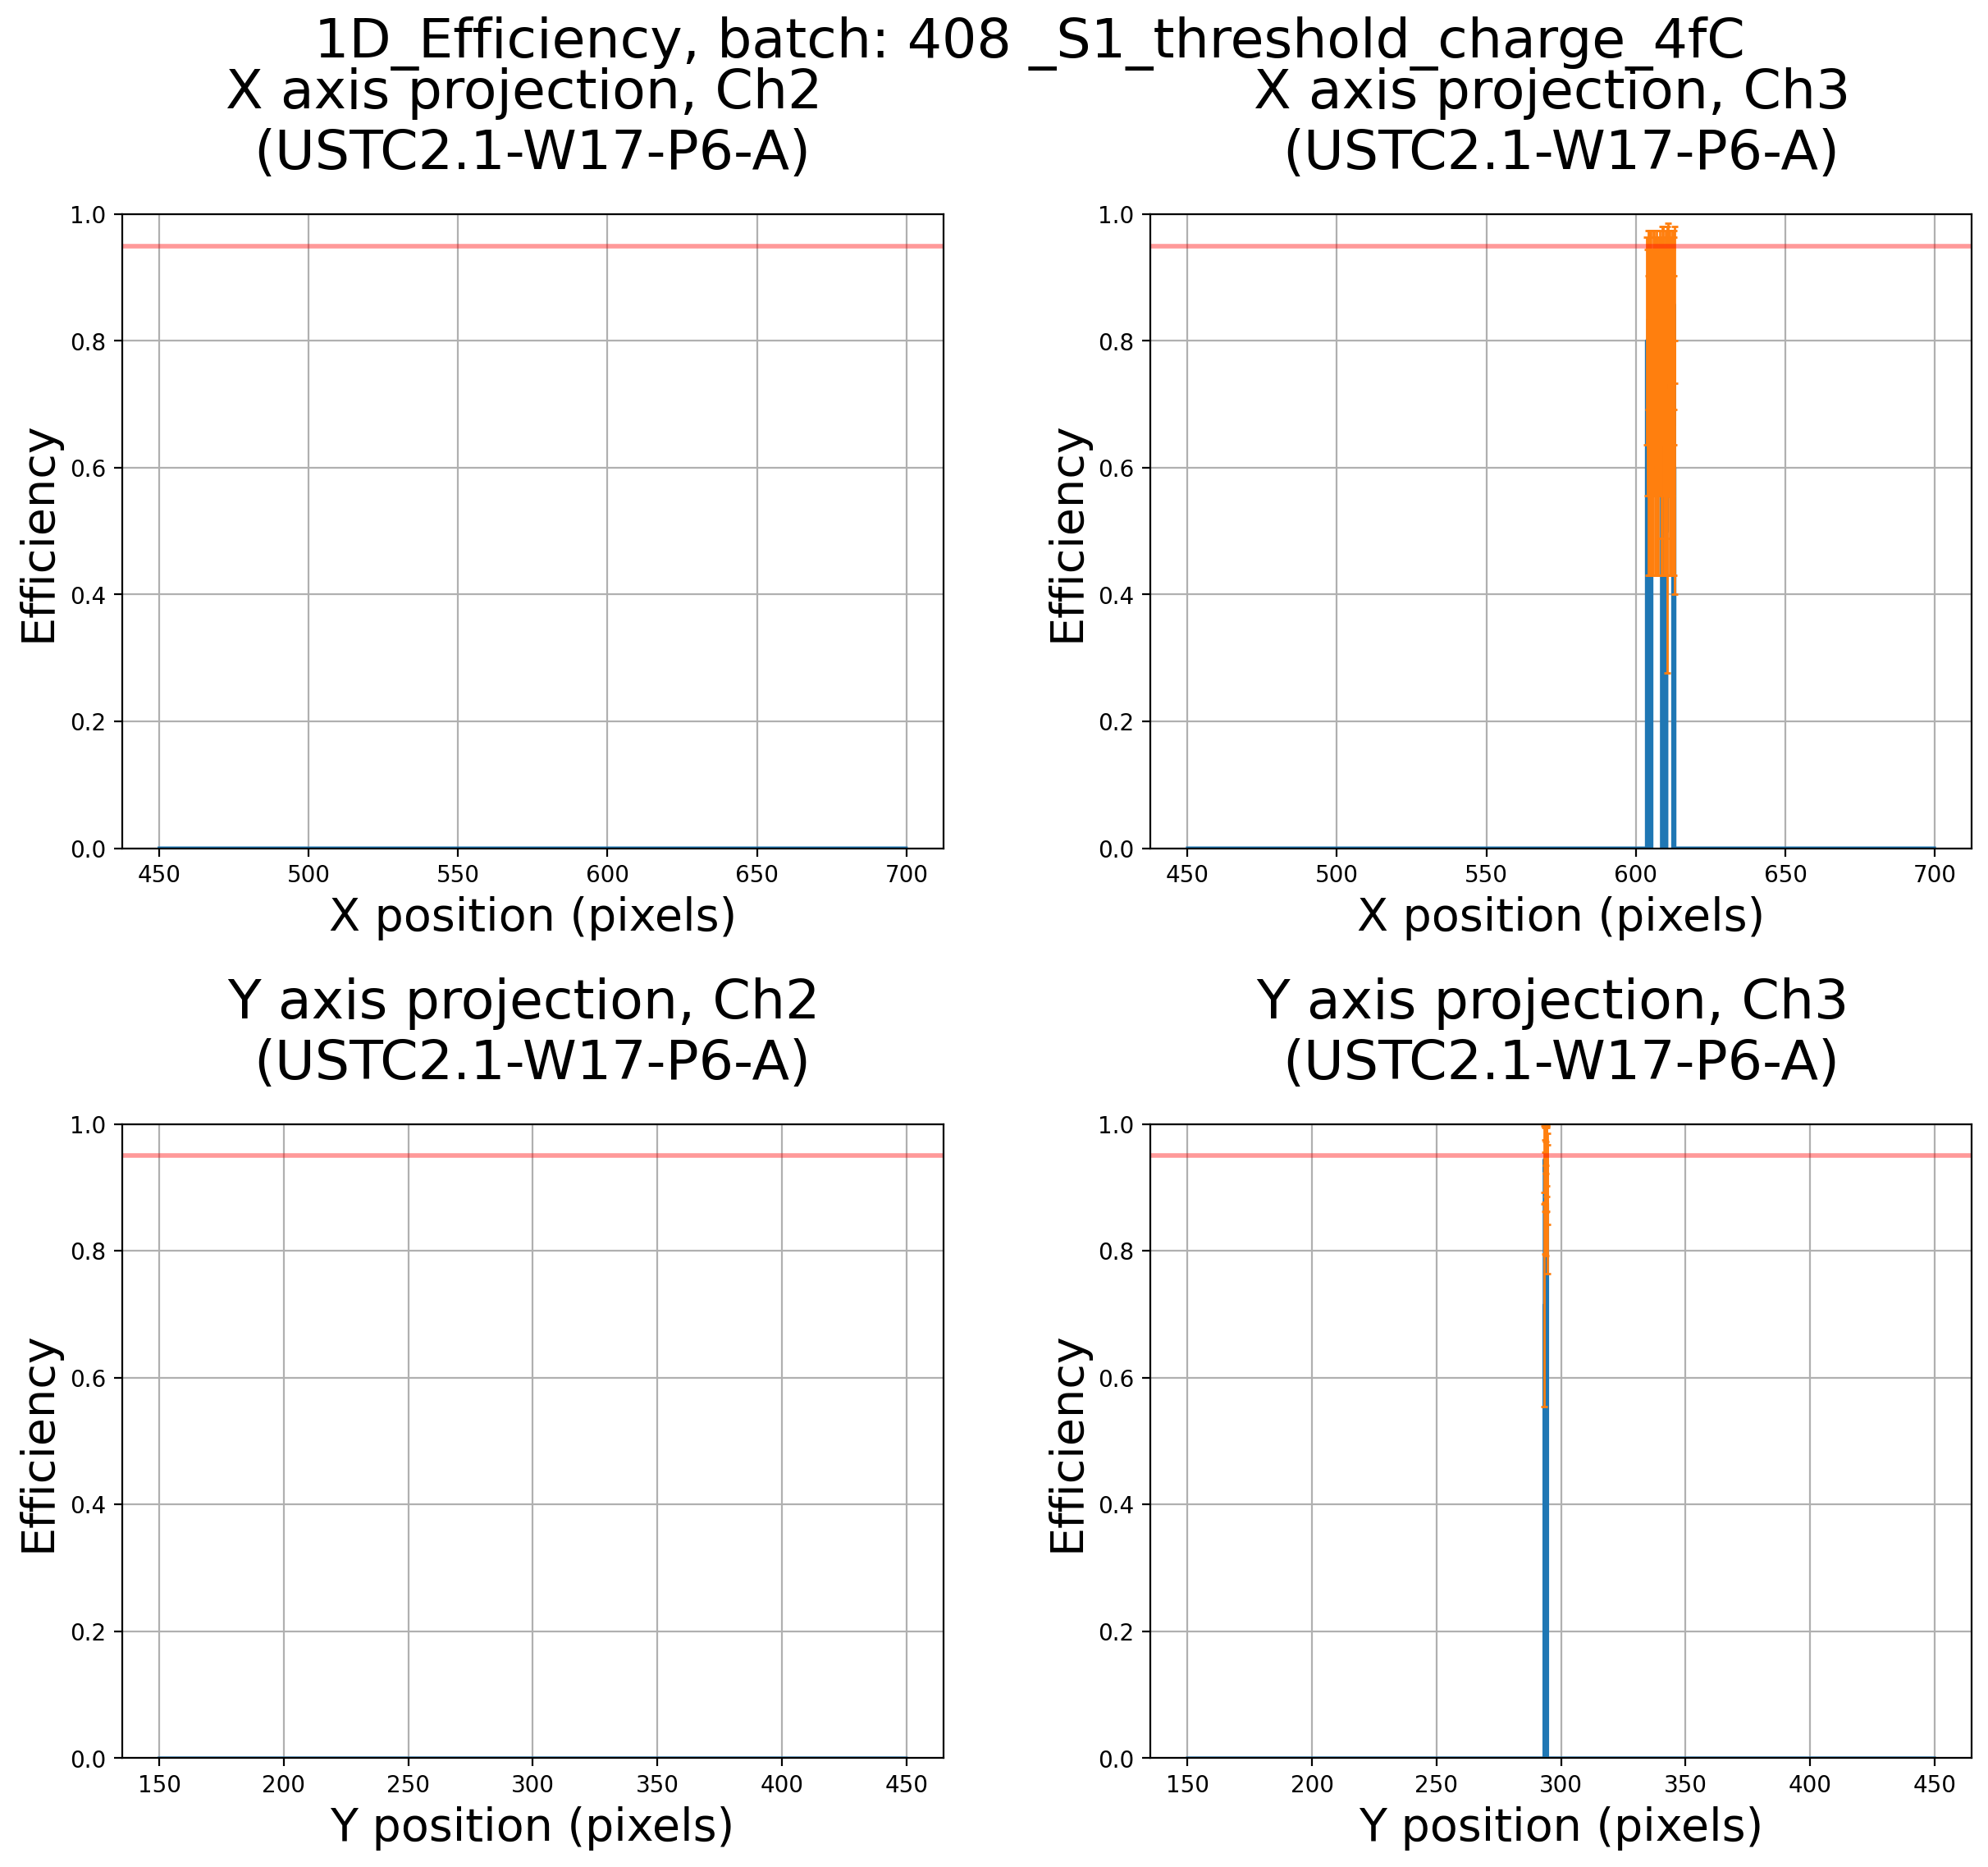

[WARNING] -	 in find_min_btw_peaks(), closing plots
[WARNING] -	 in find_min_btw_peaks(), closing plots


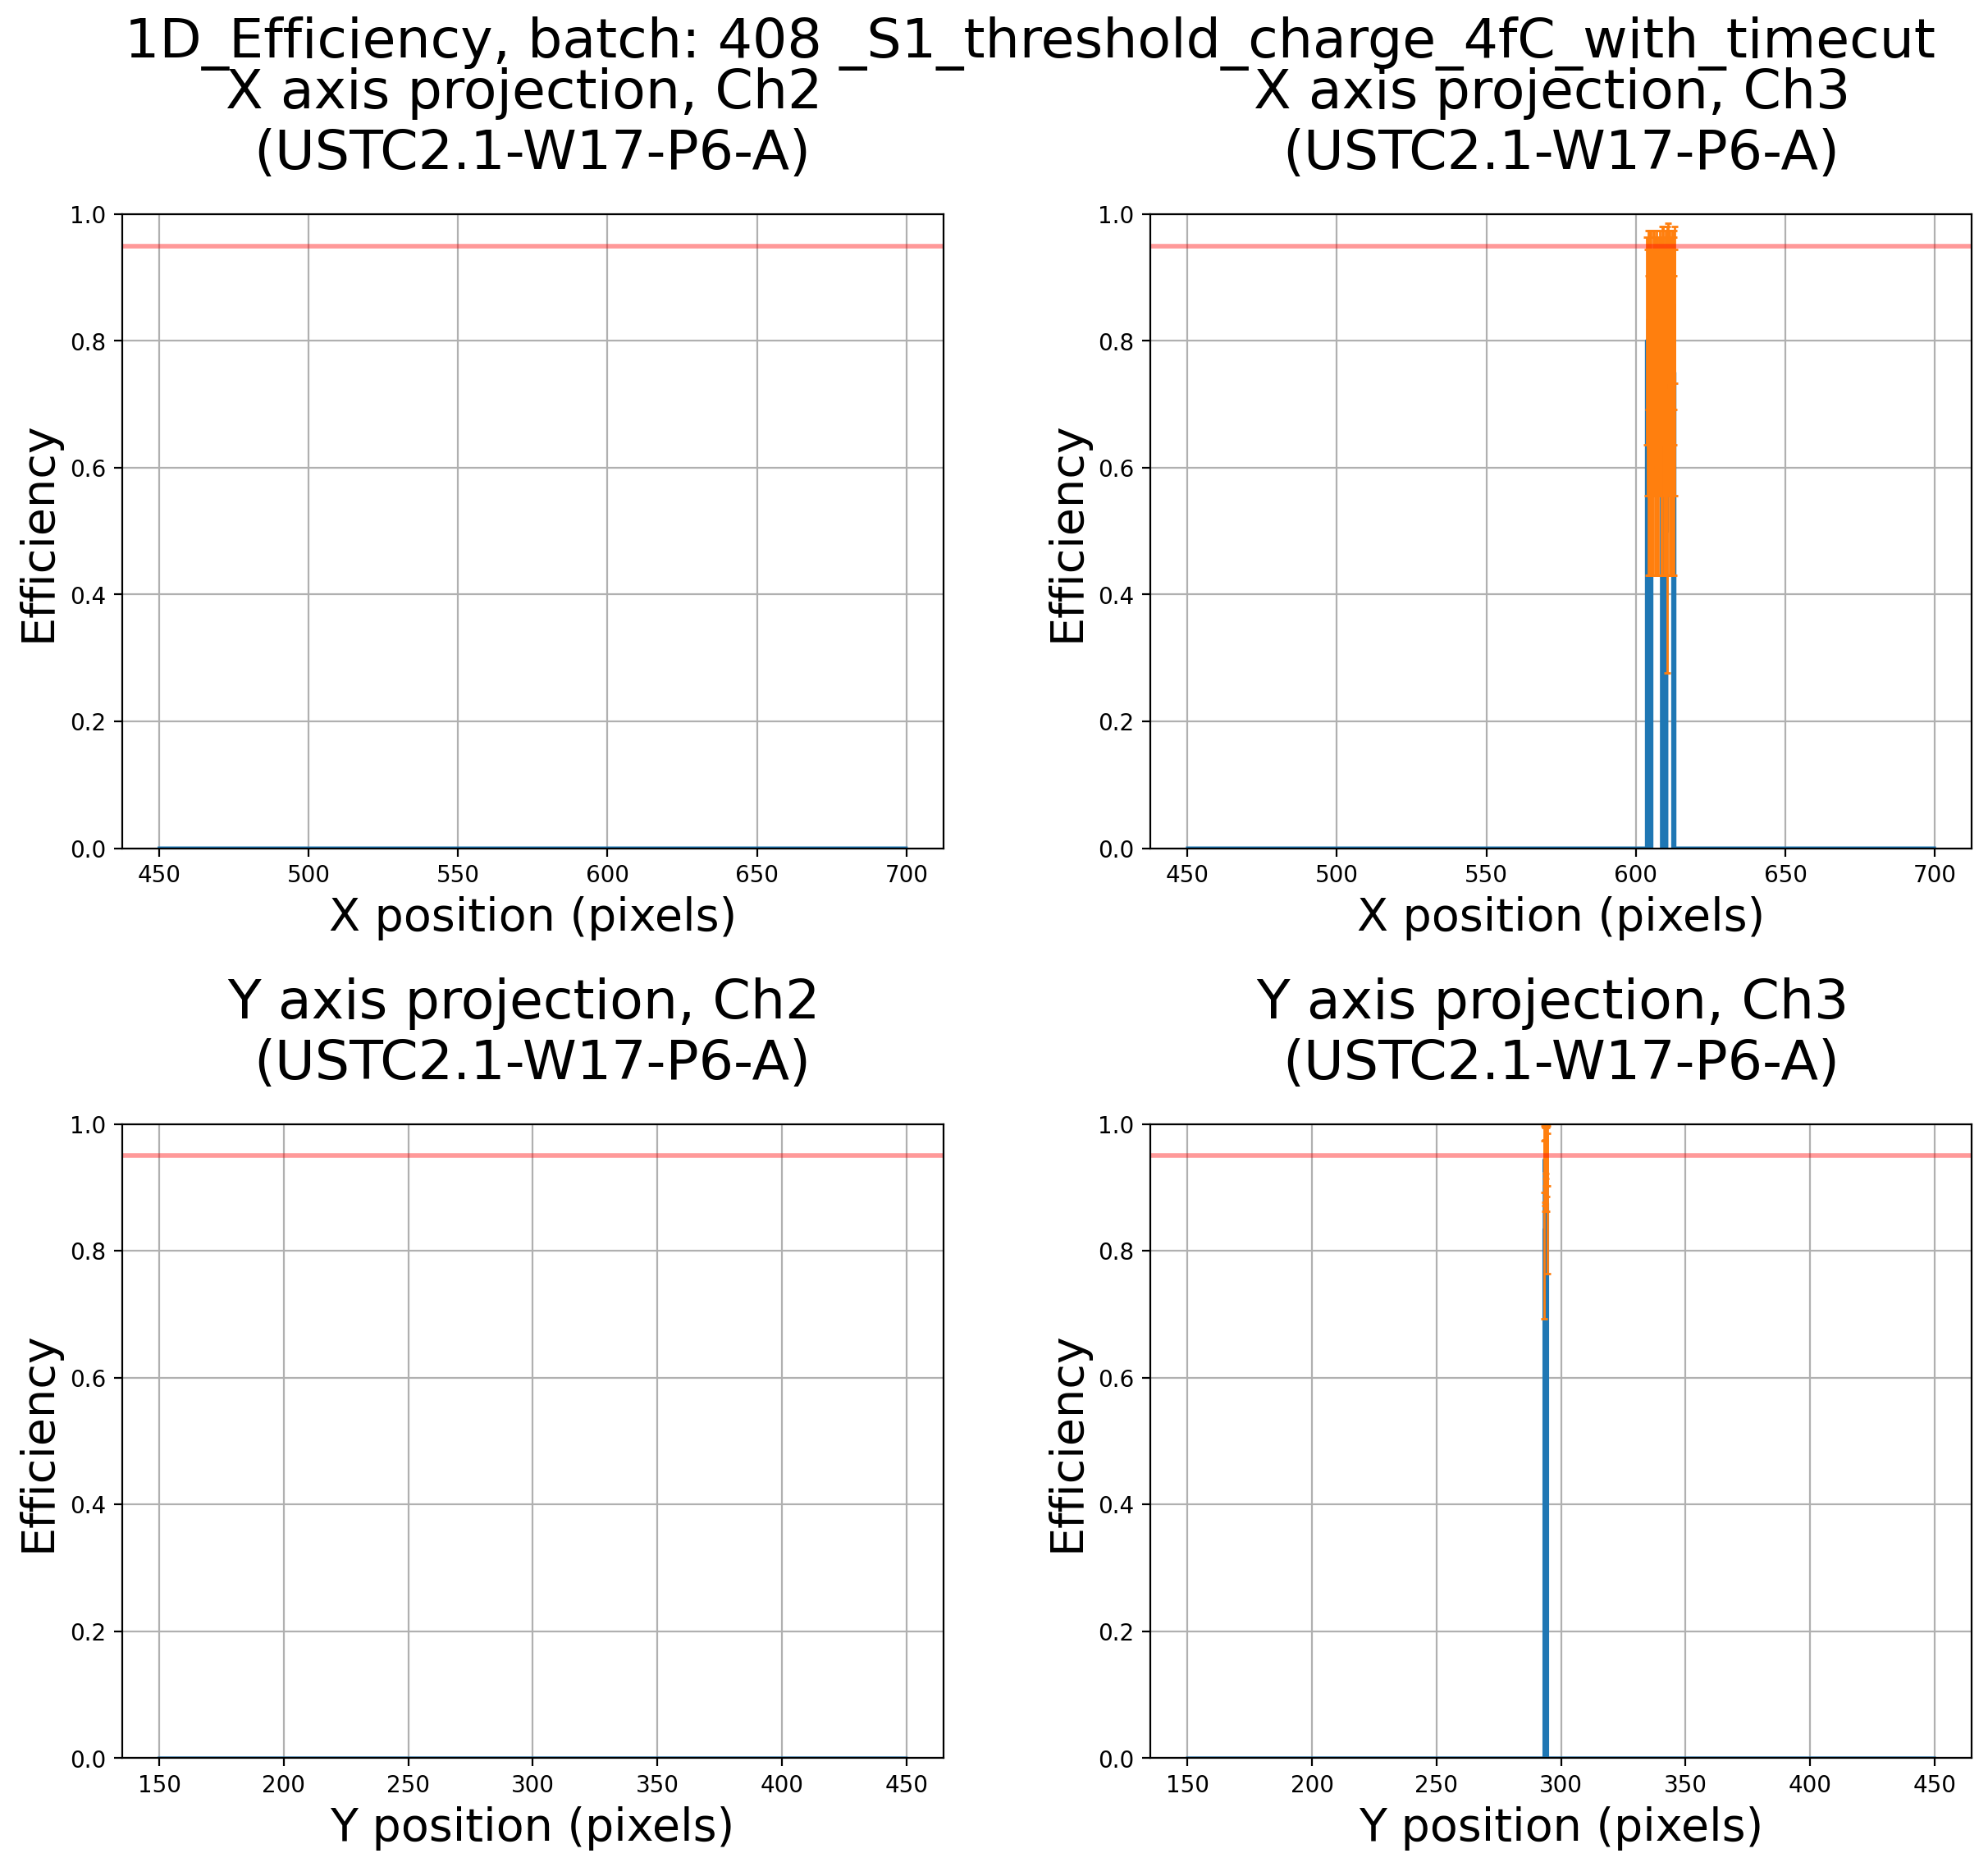

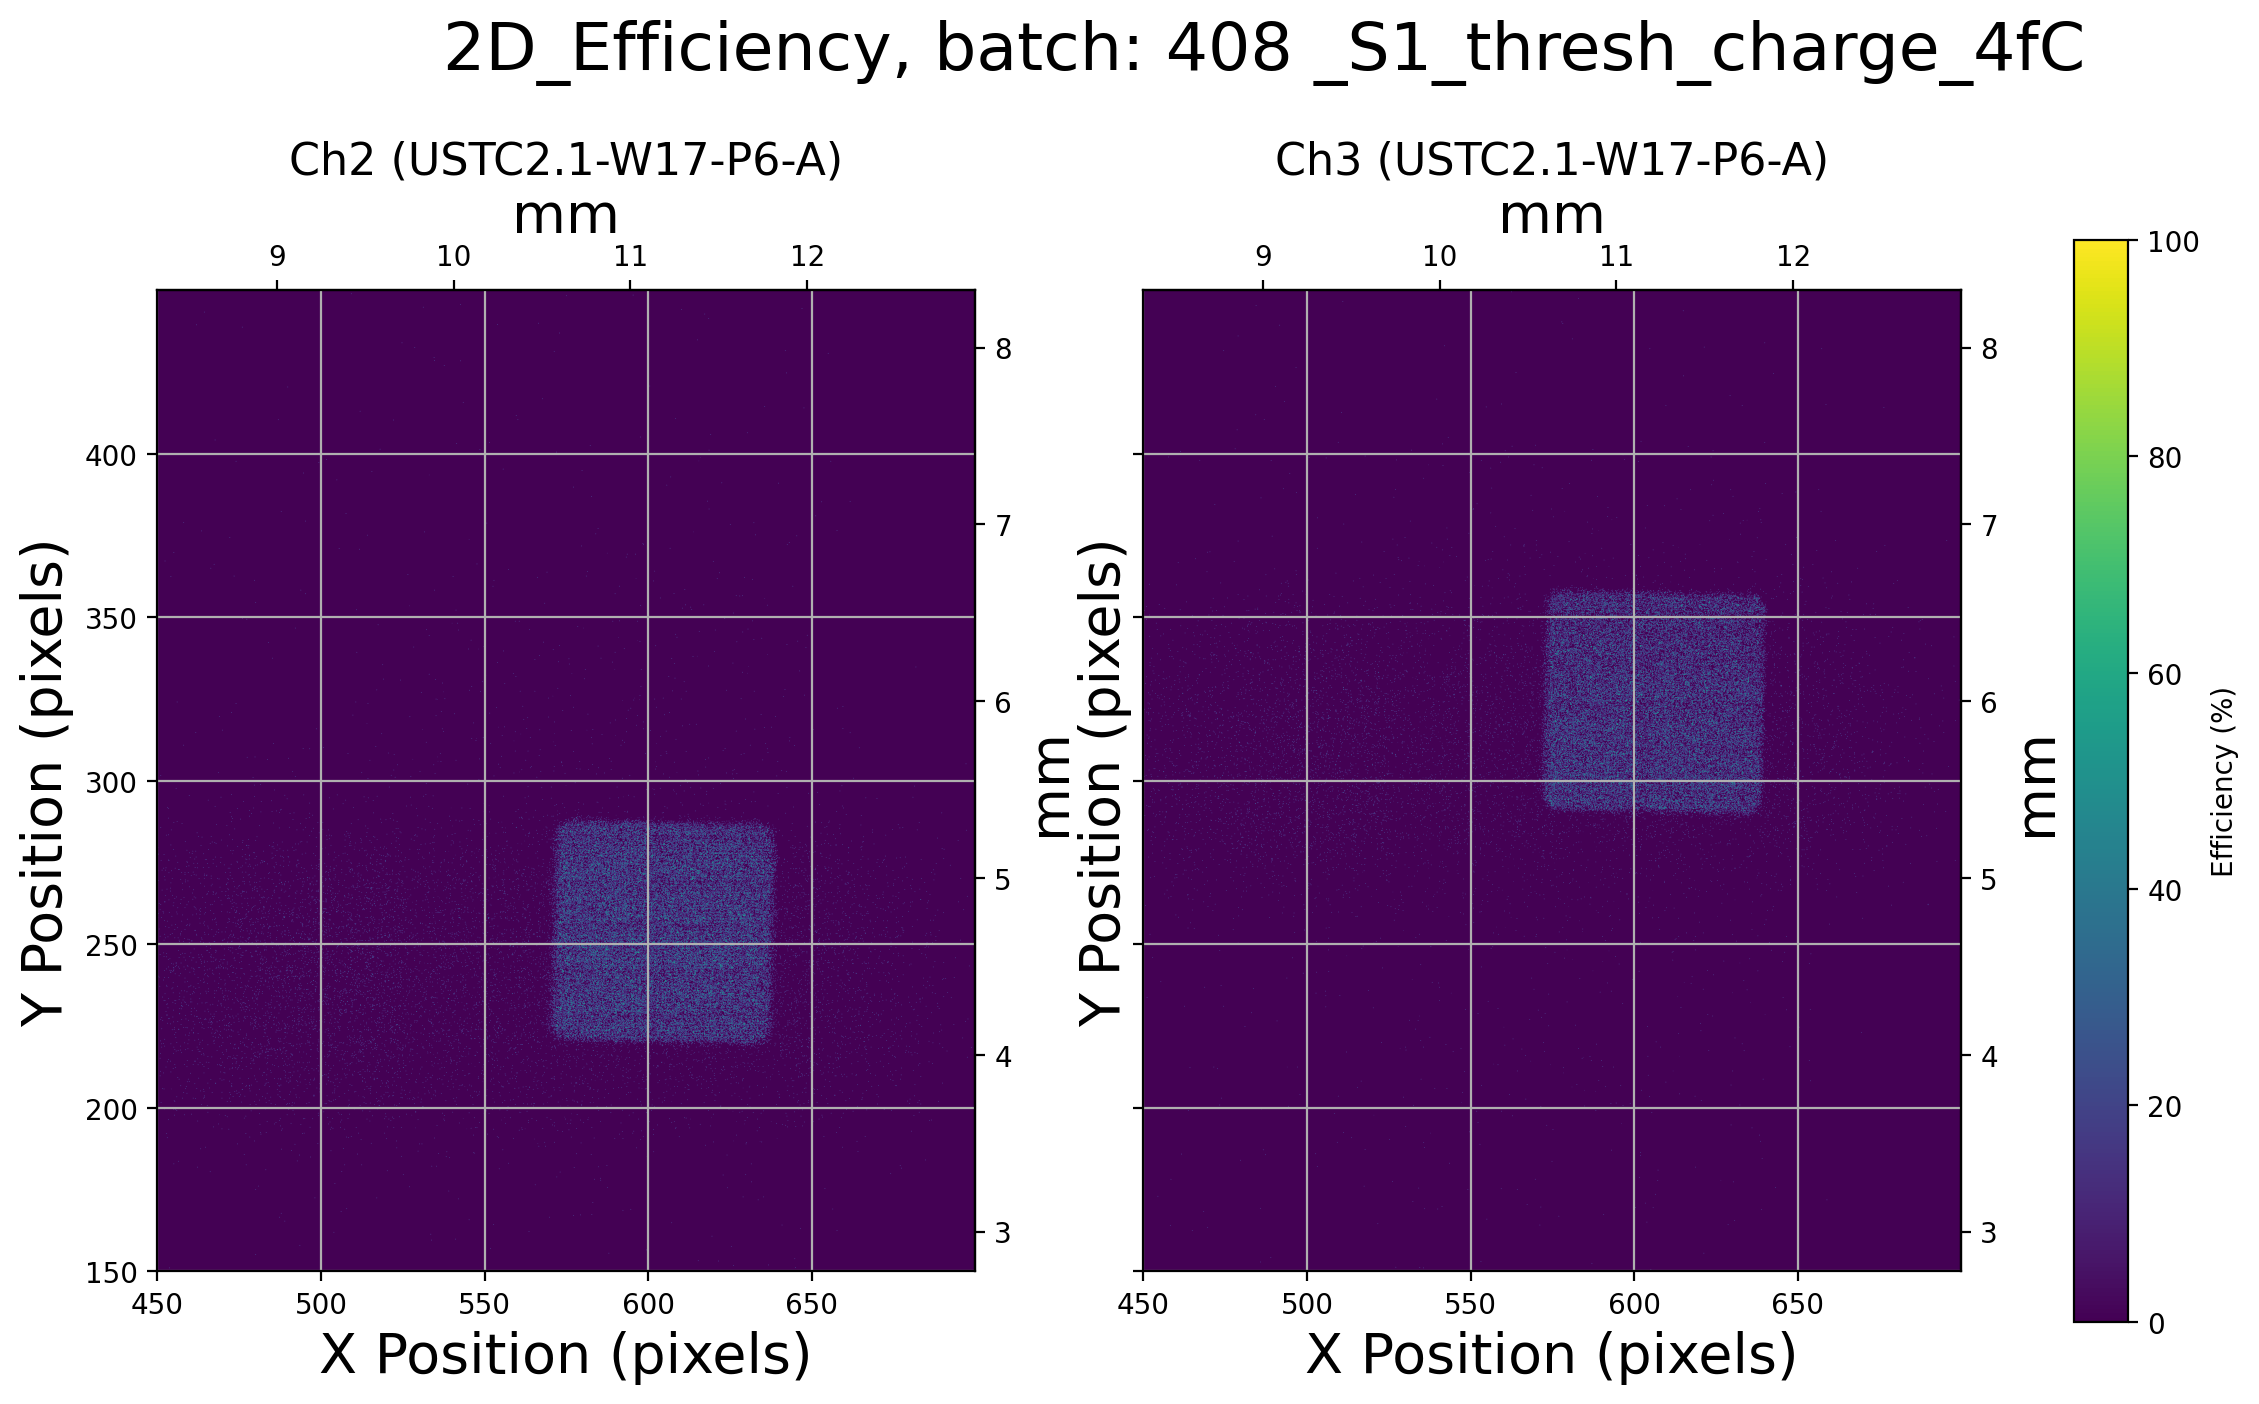

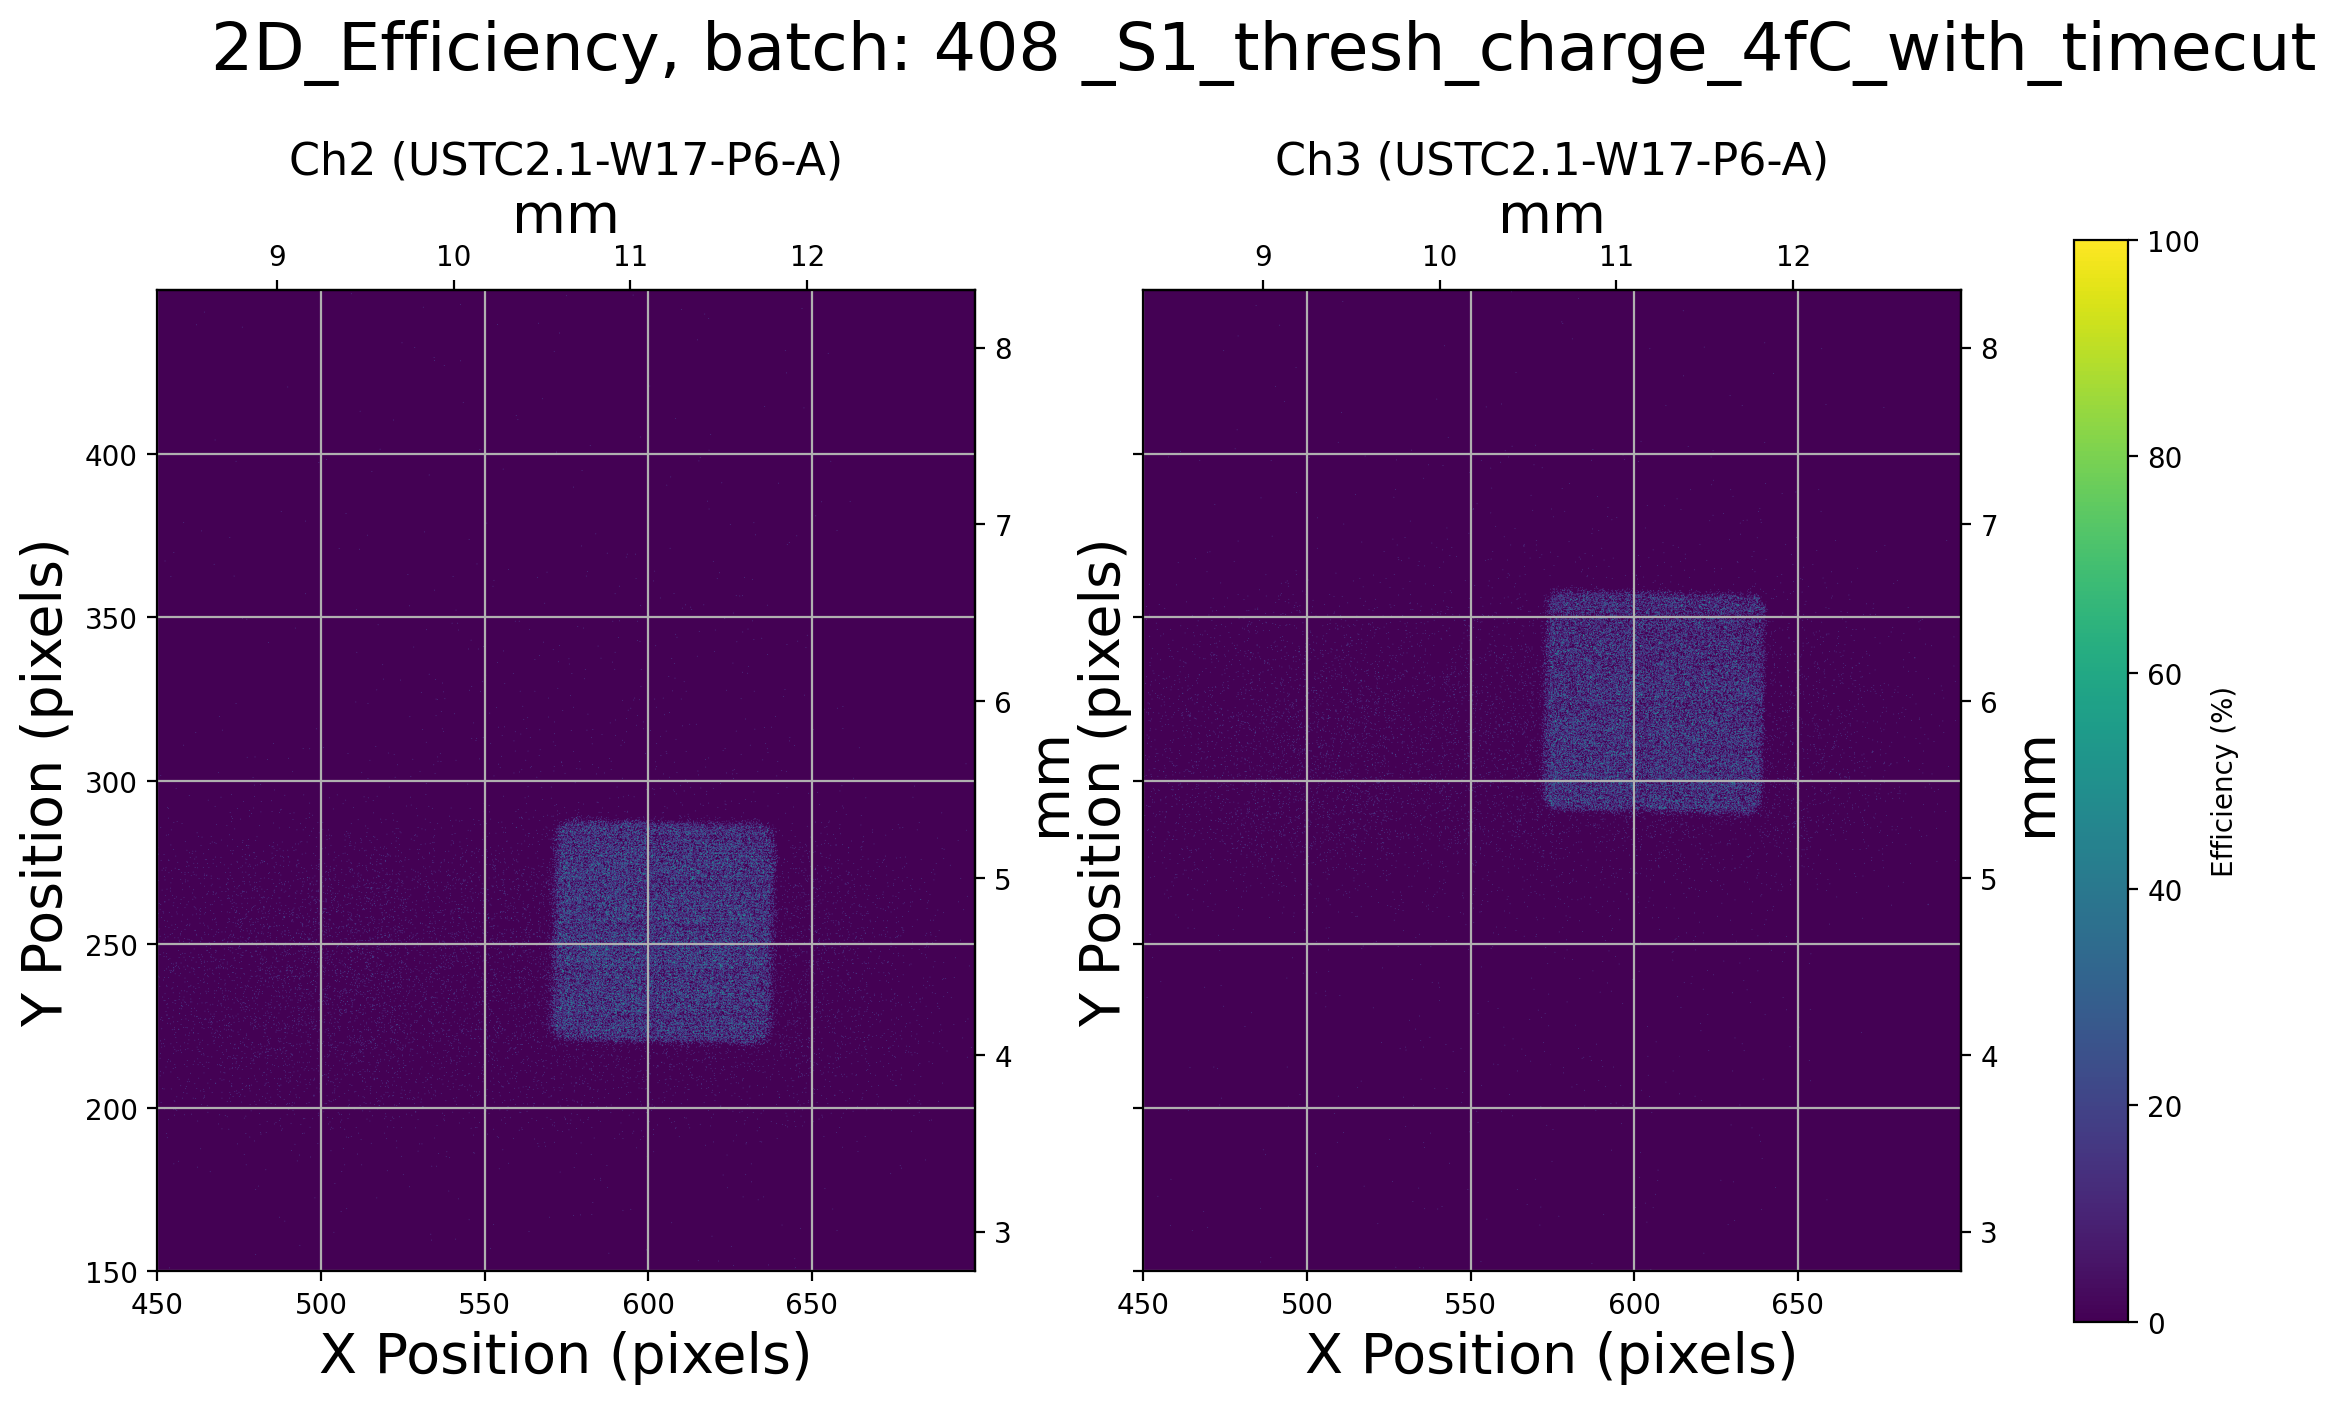

[WARNING] -	 in time_mask() plot has been closed
[WARNING] -	 in time_mask() plot has been closed


DUT_1
DUT_2


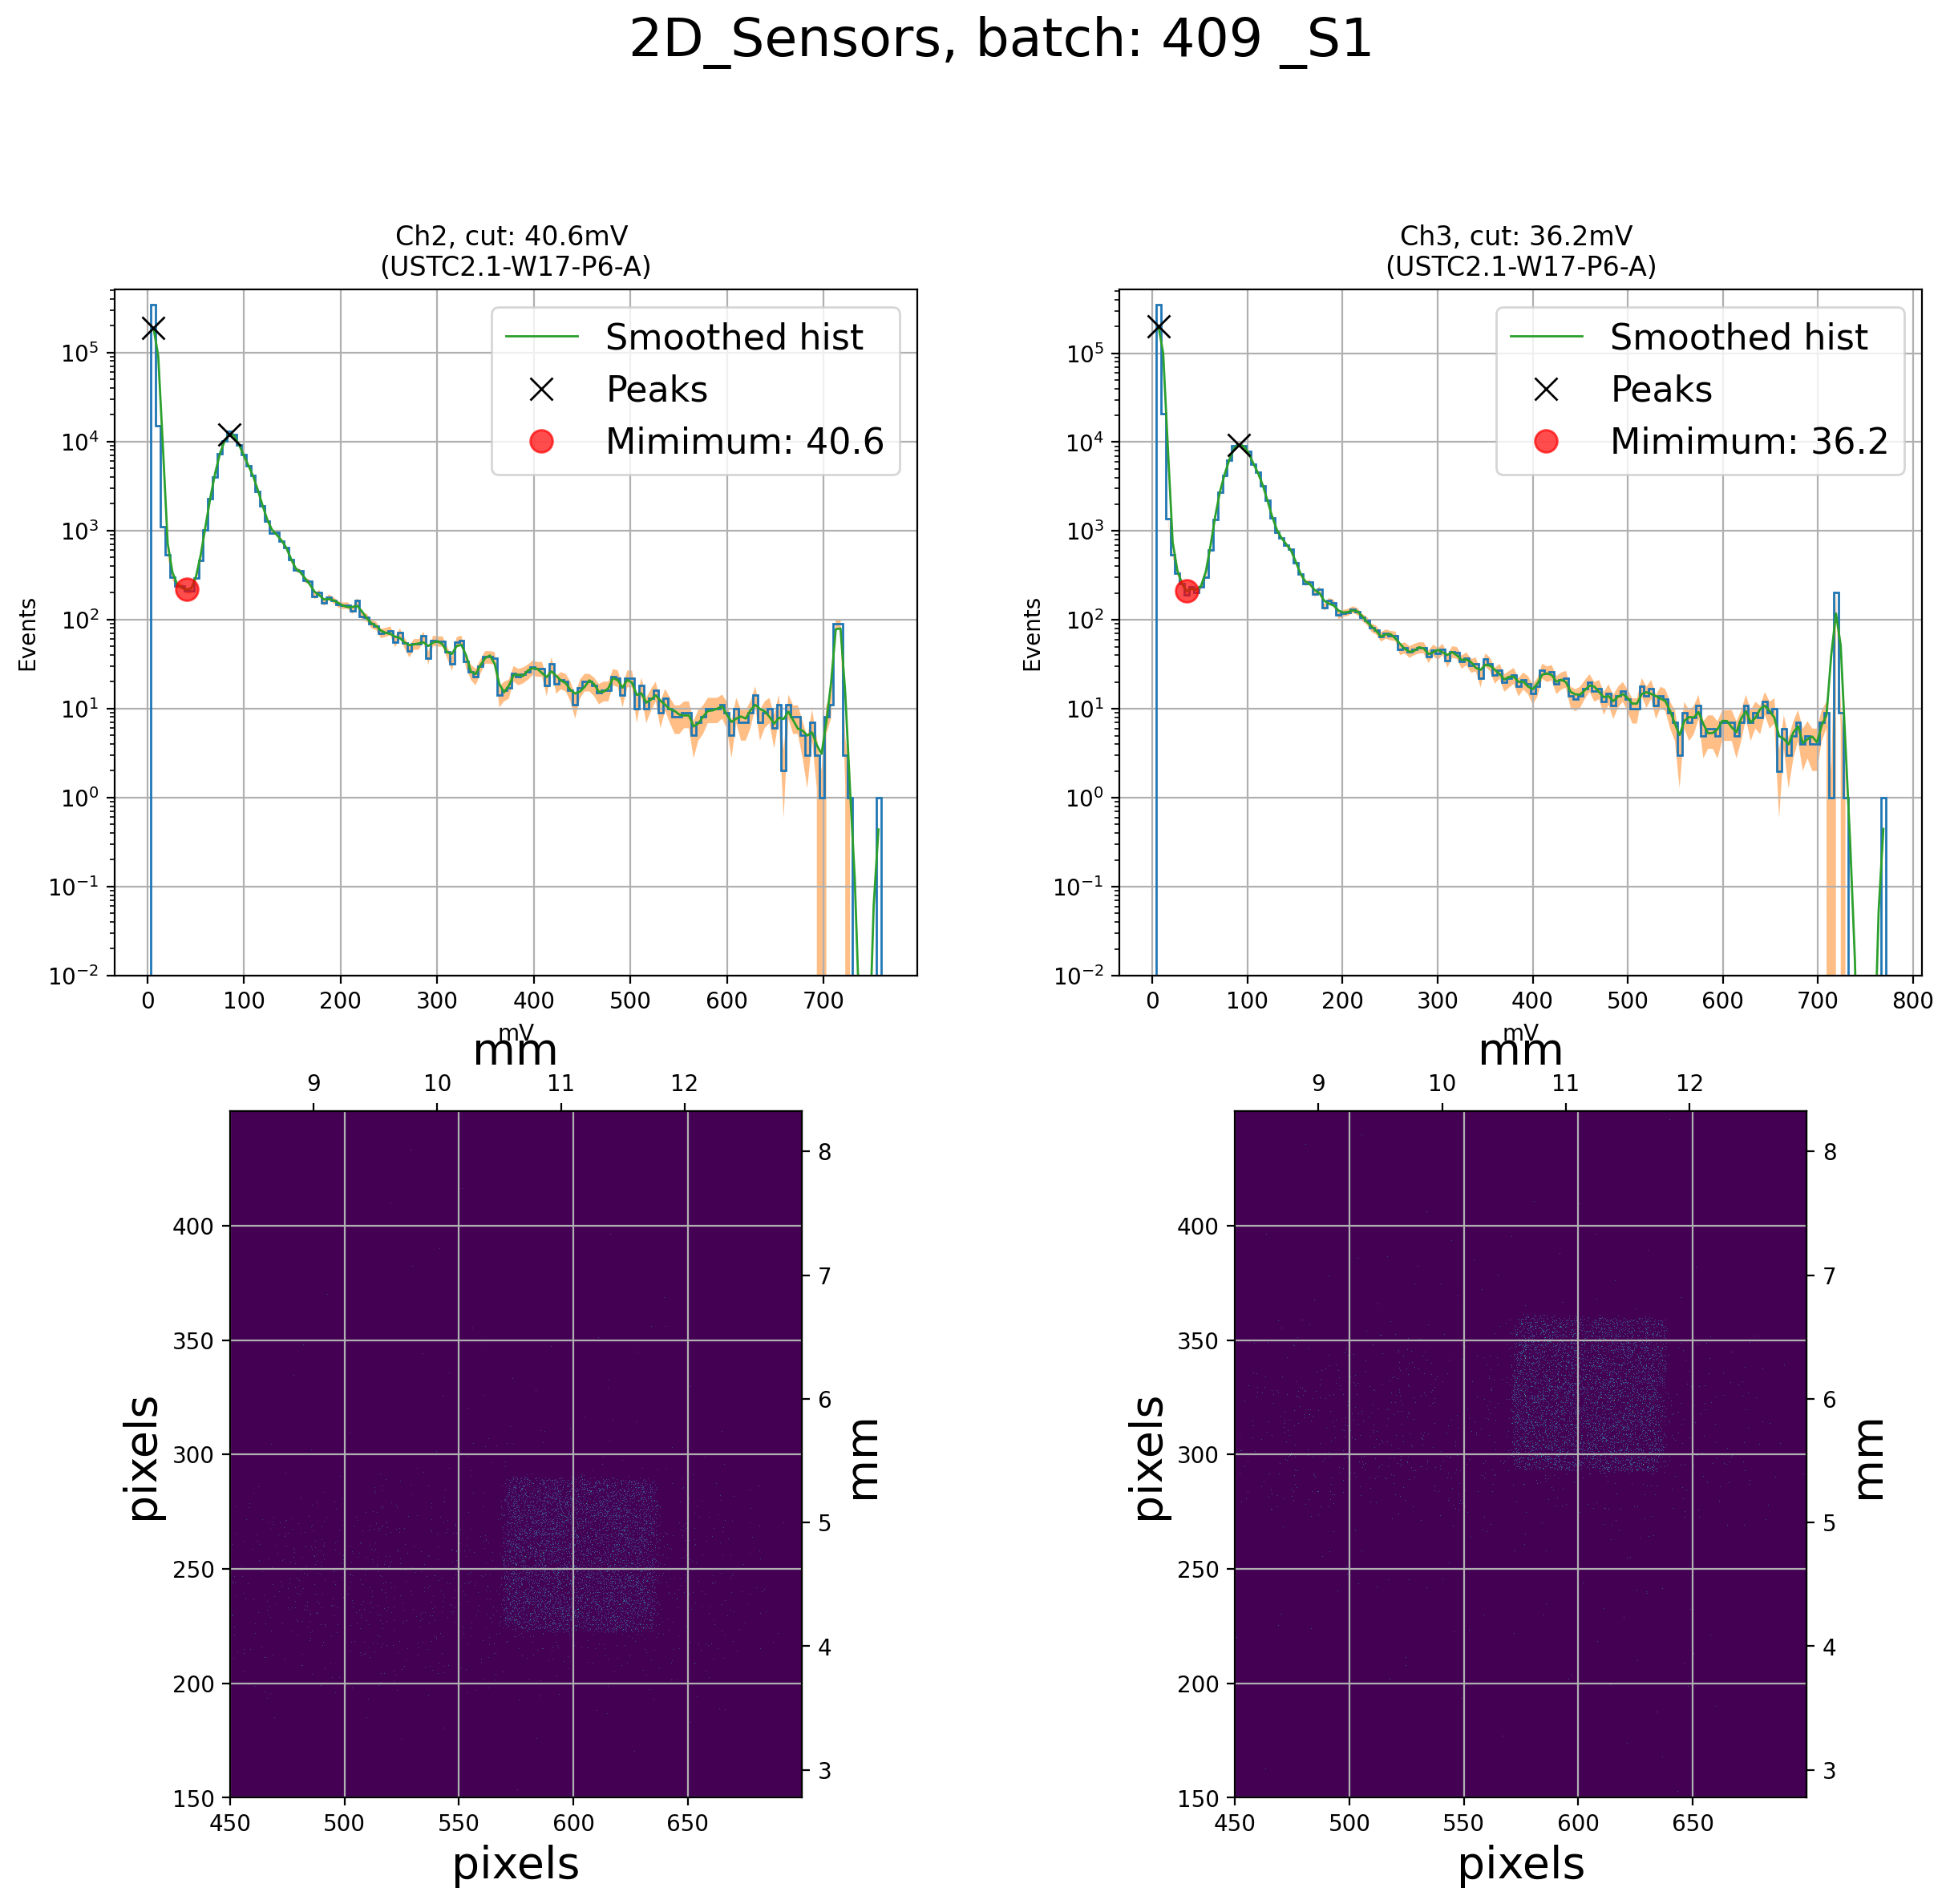

[WARNING] -	 in find_min_btw_peaks(), closing plots
[WARNING] -	 in find_min_btw_peaks(), closing plots


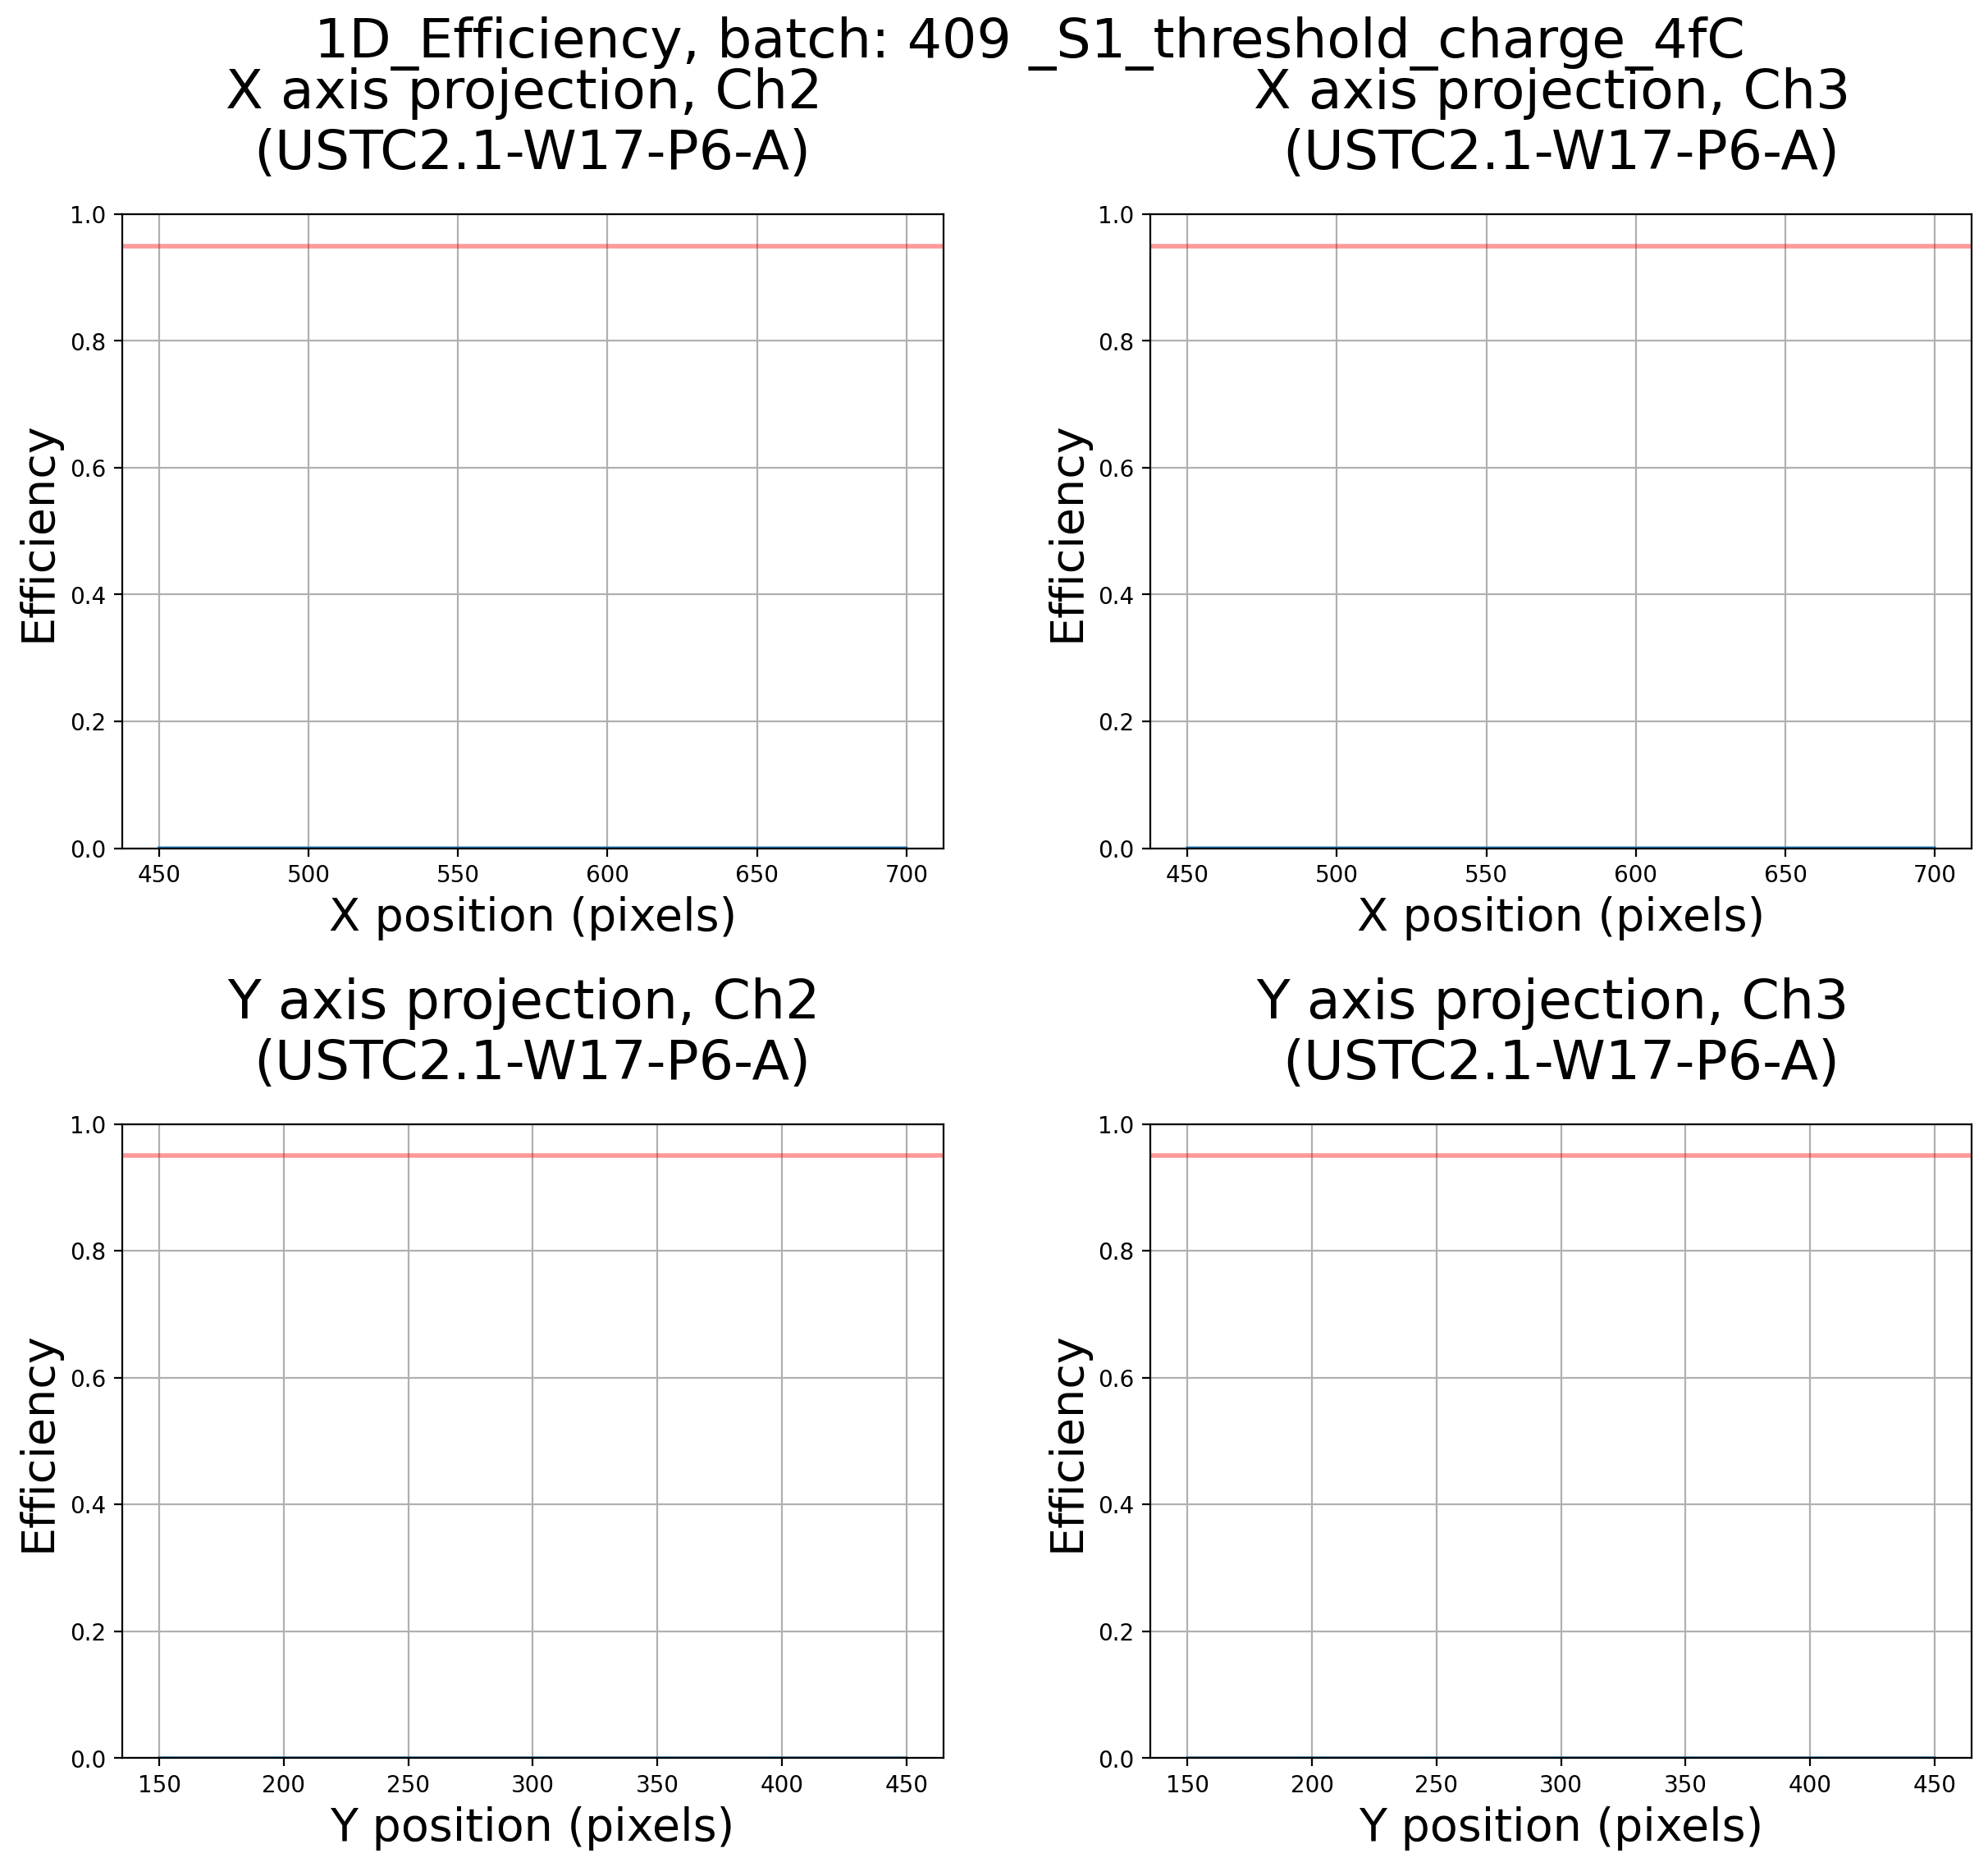

[WARNING] -	 in find_min_btw_peaks(), closing plots
[WARNING] -	 in find_min_btw_peaks(), closing plots


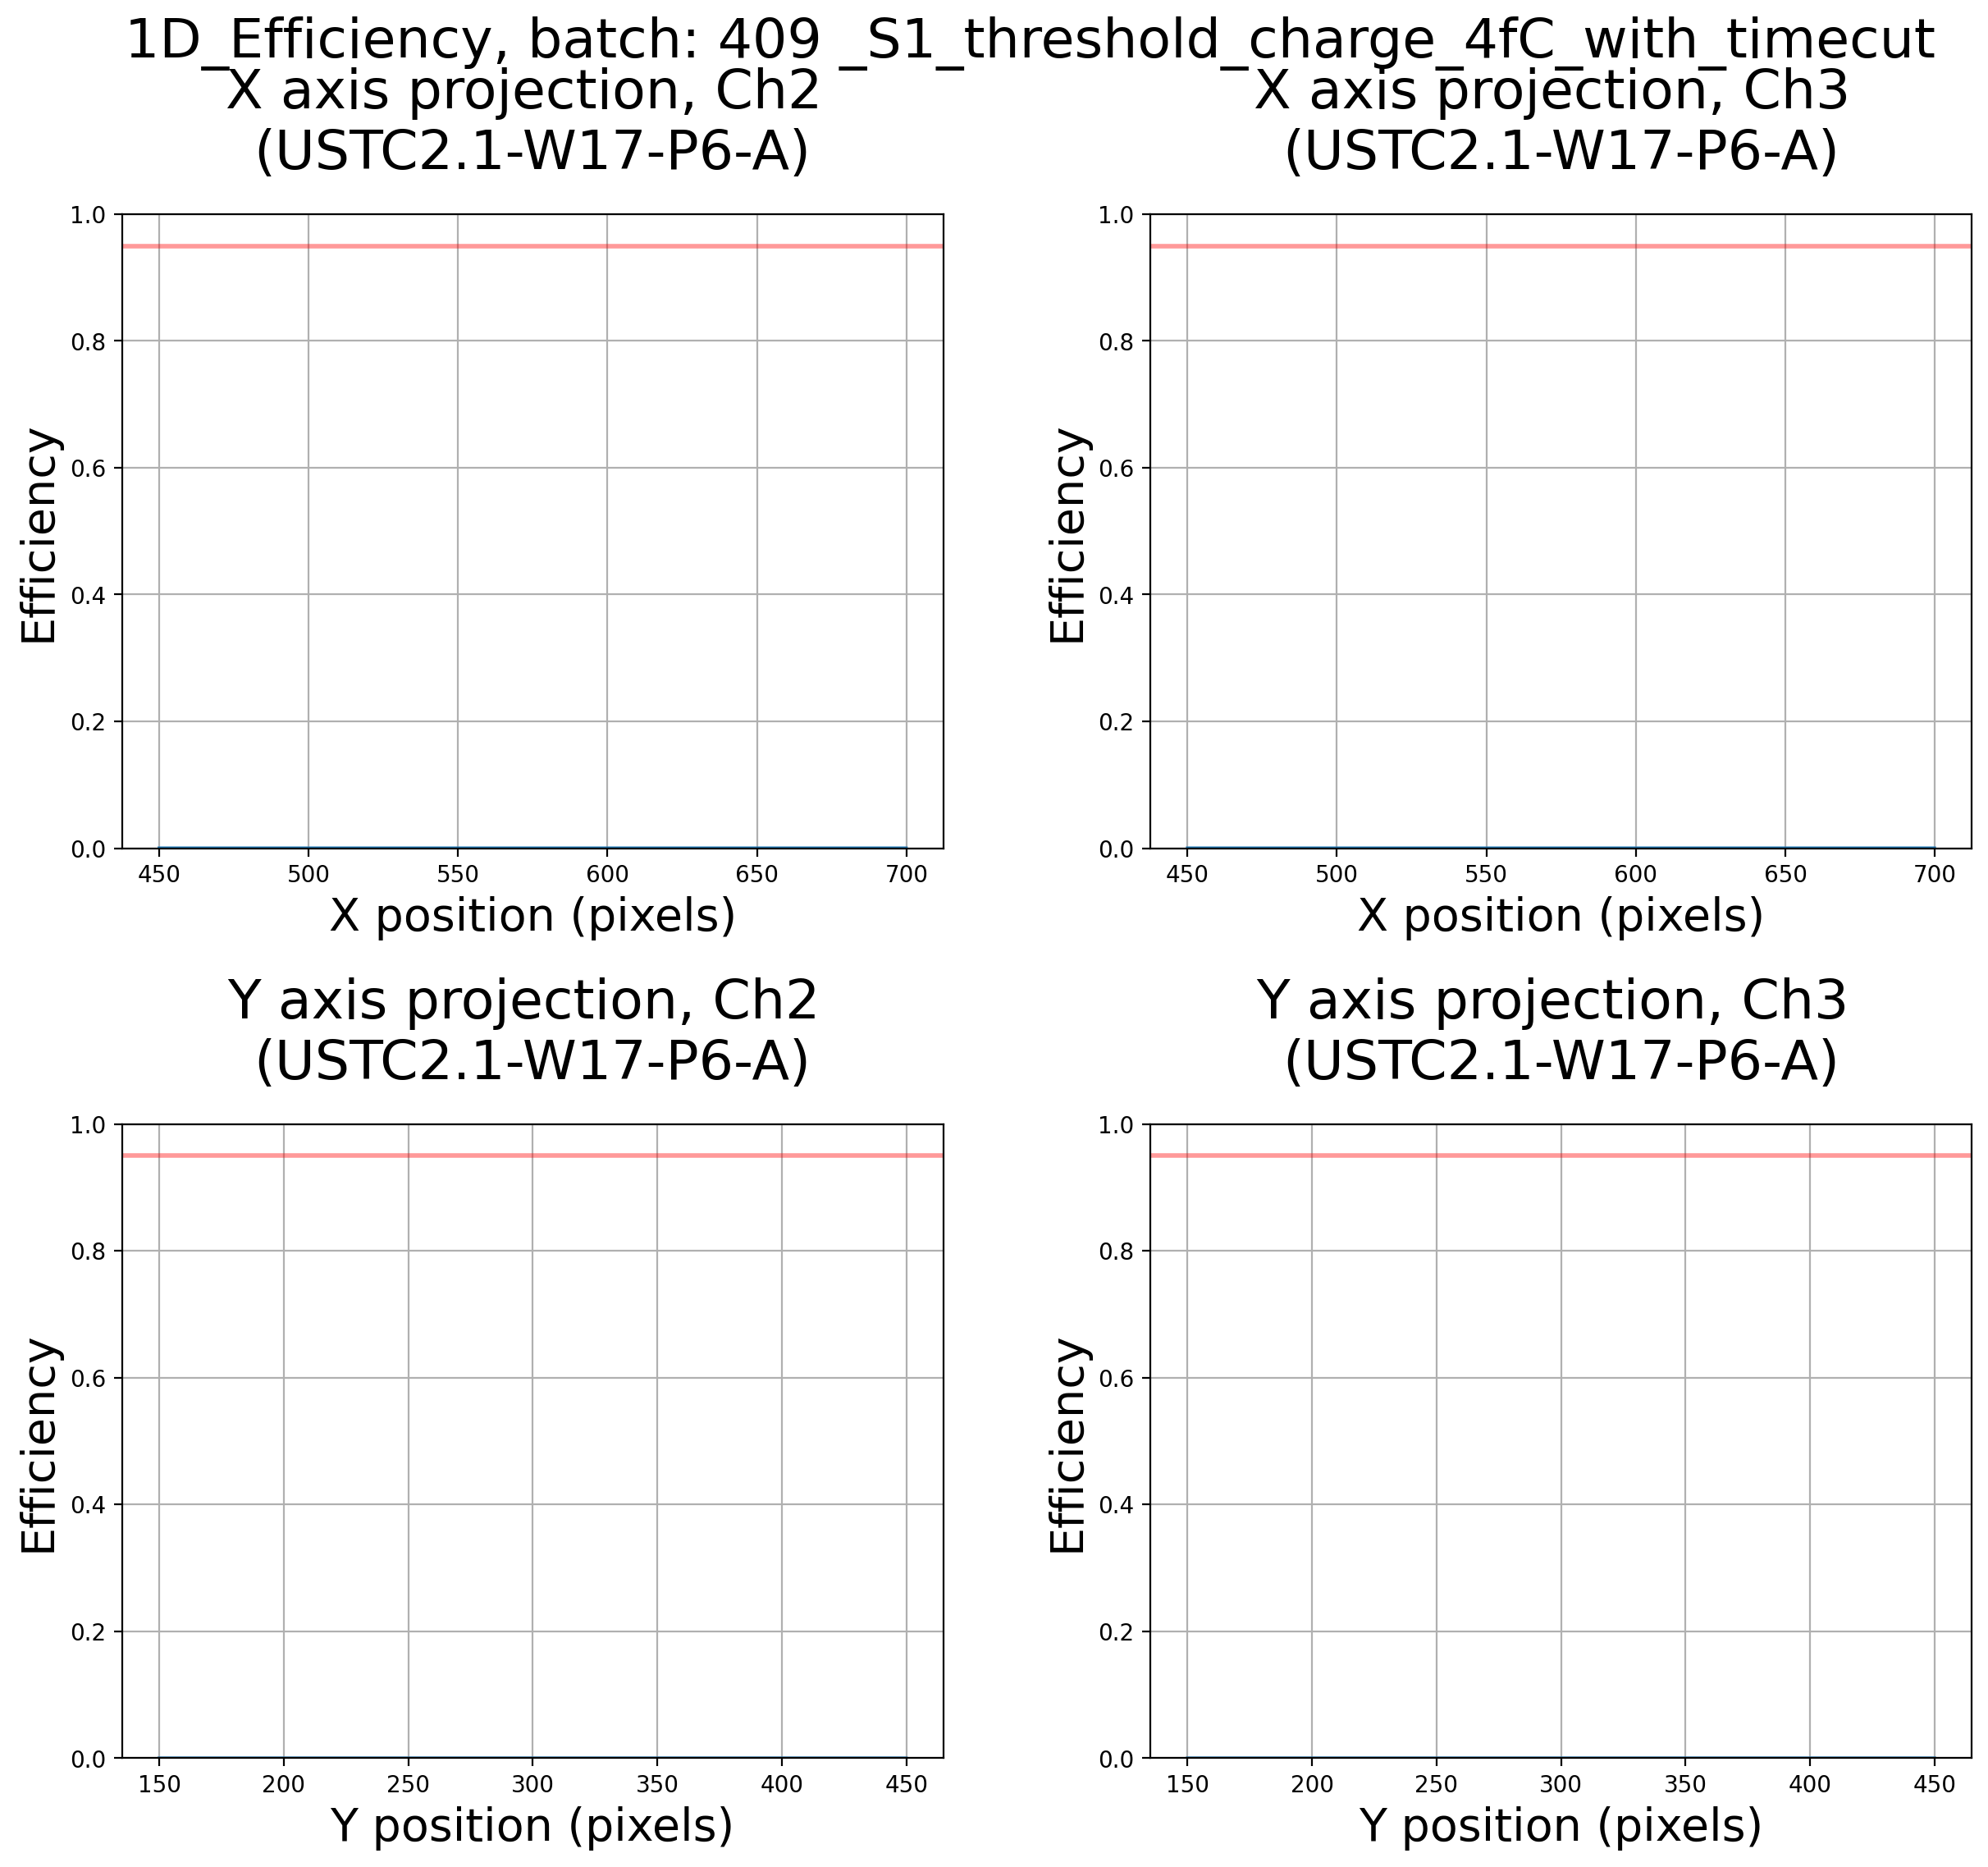

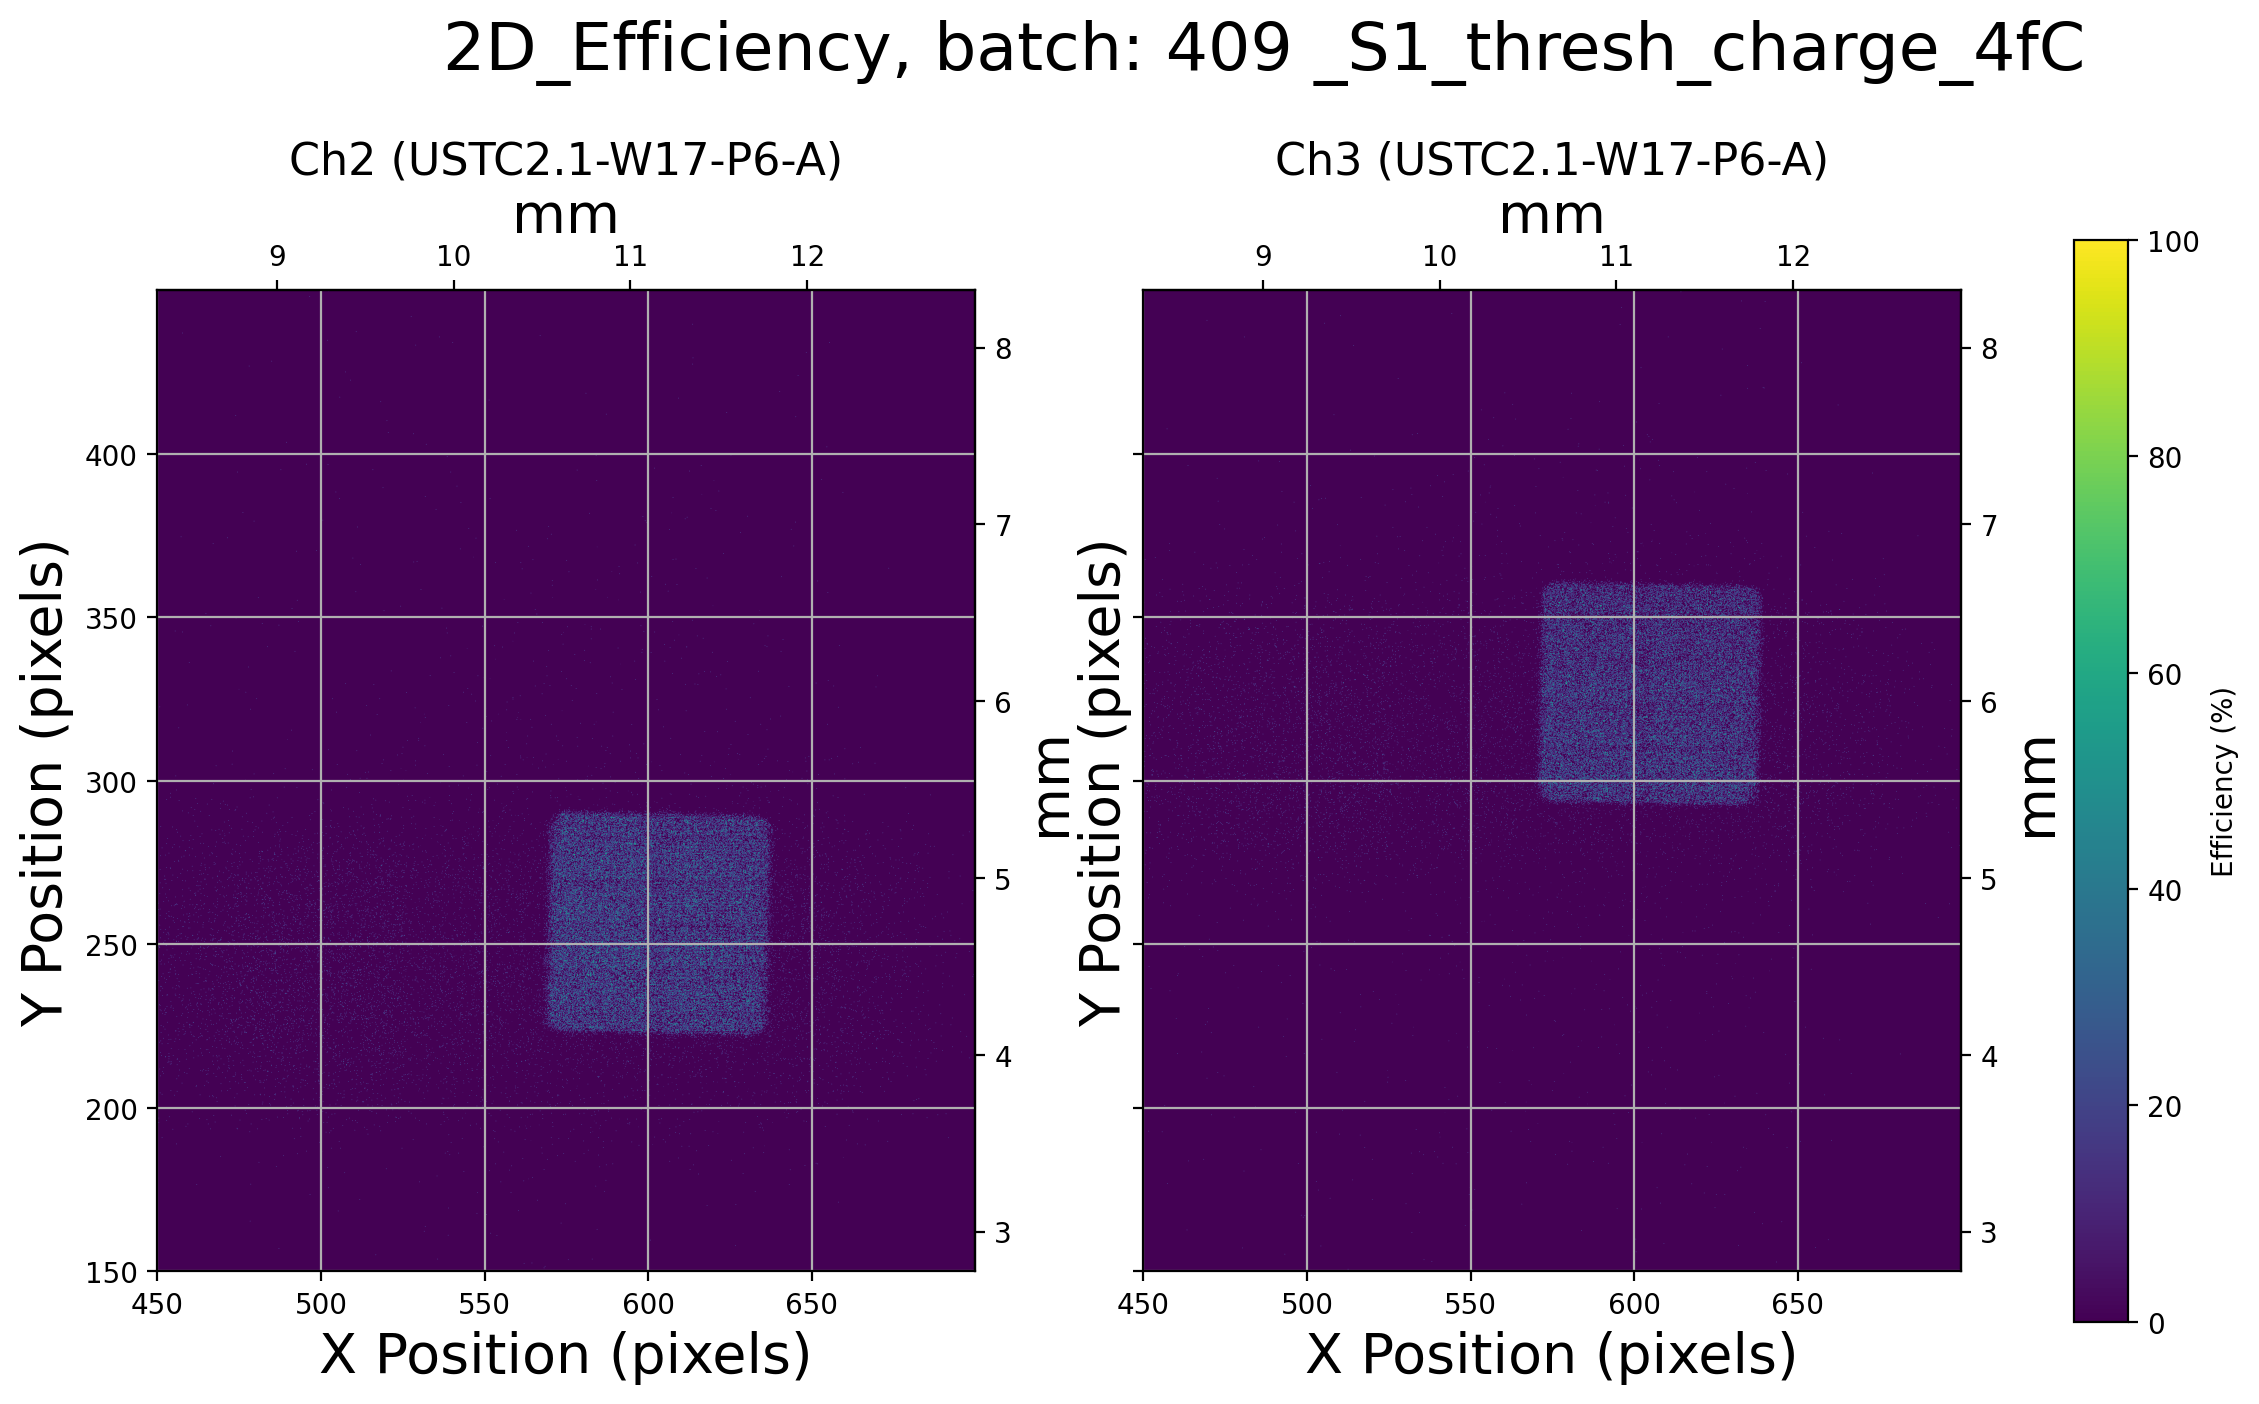

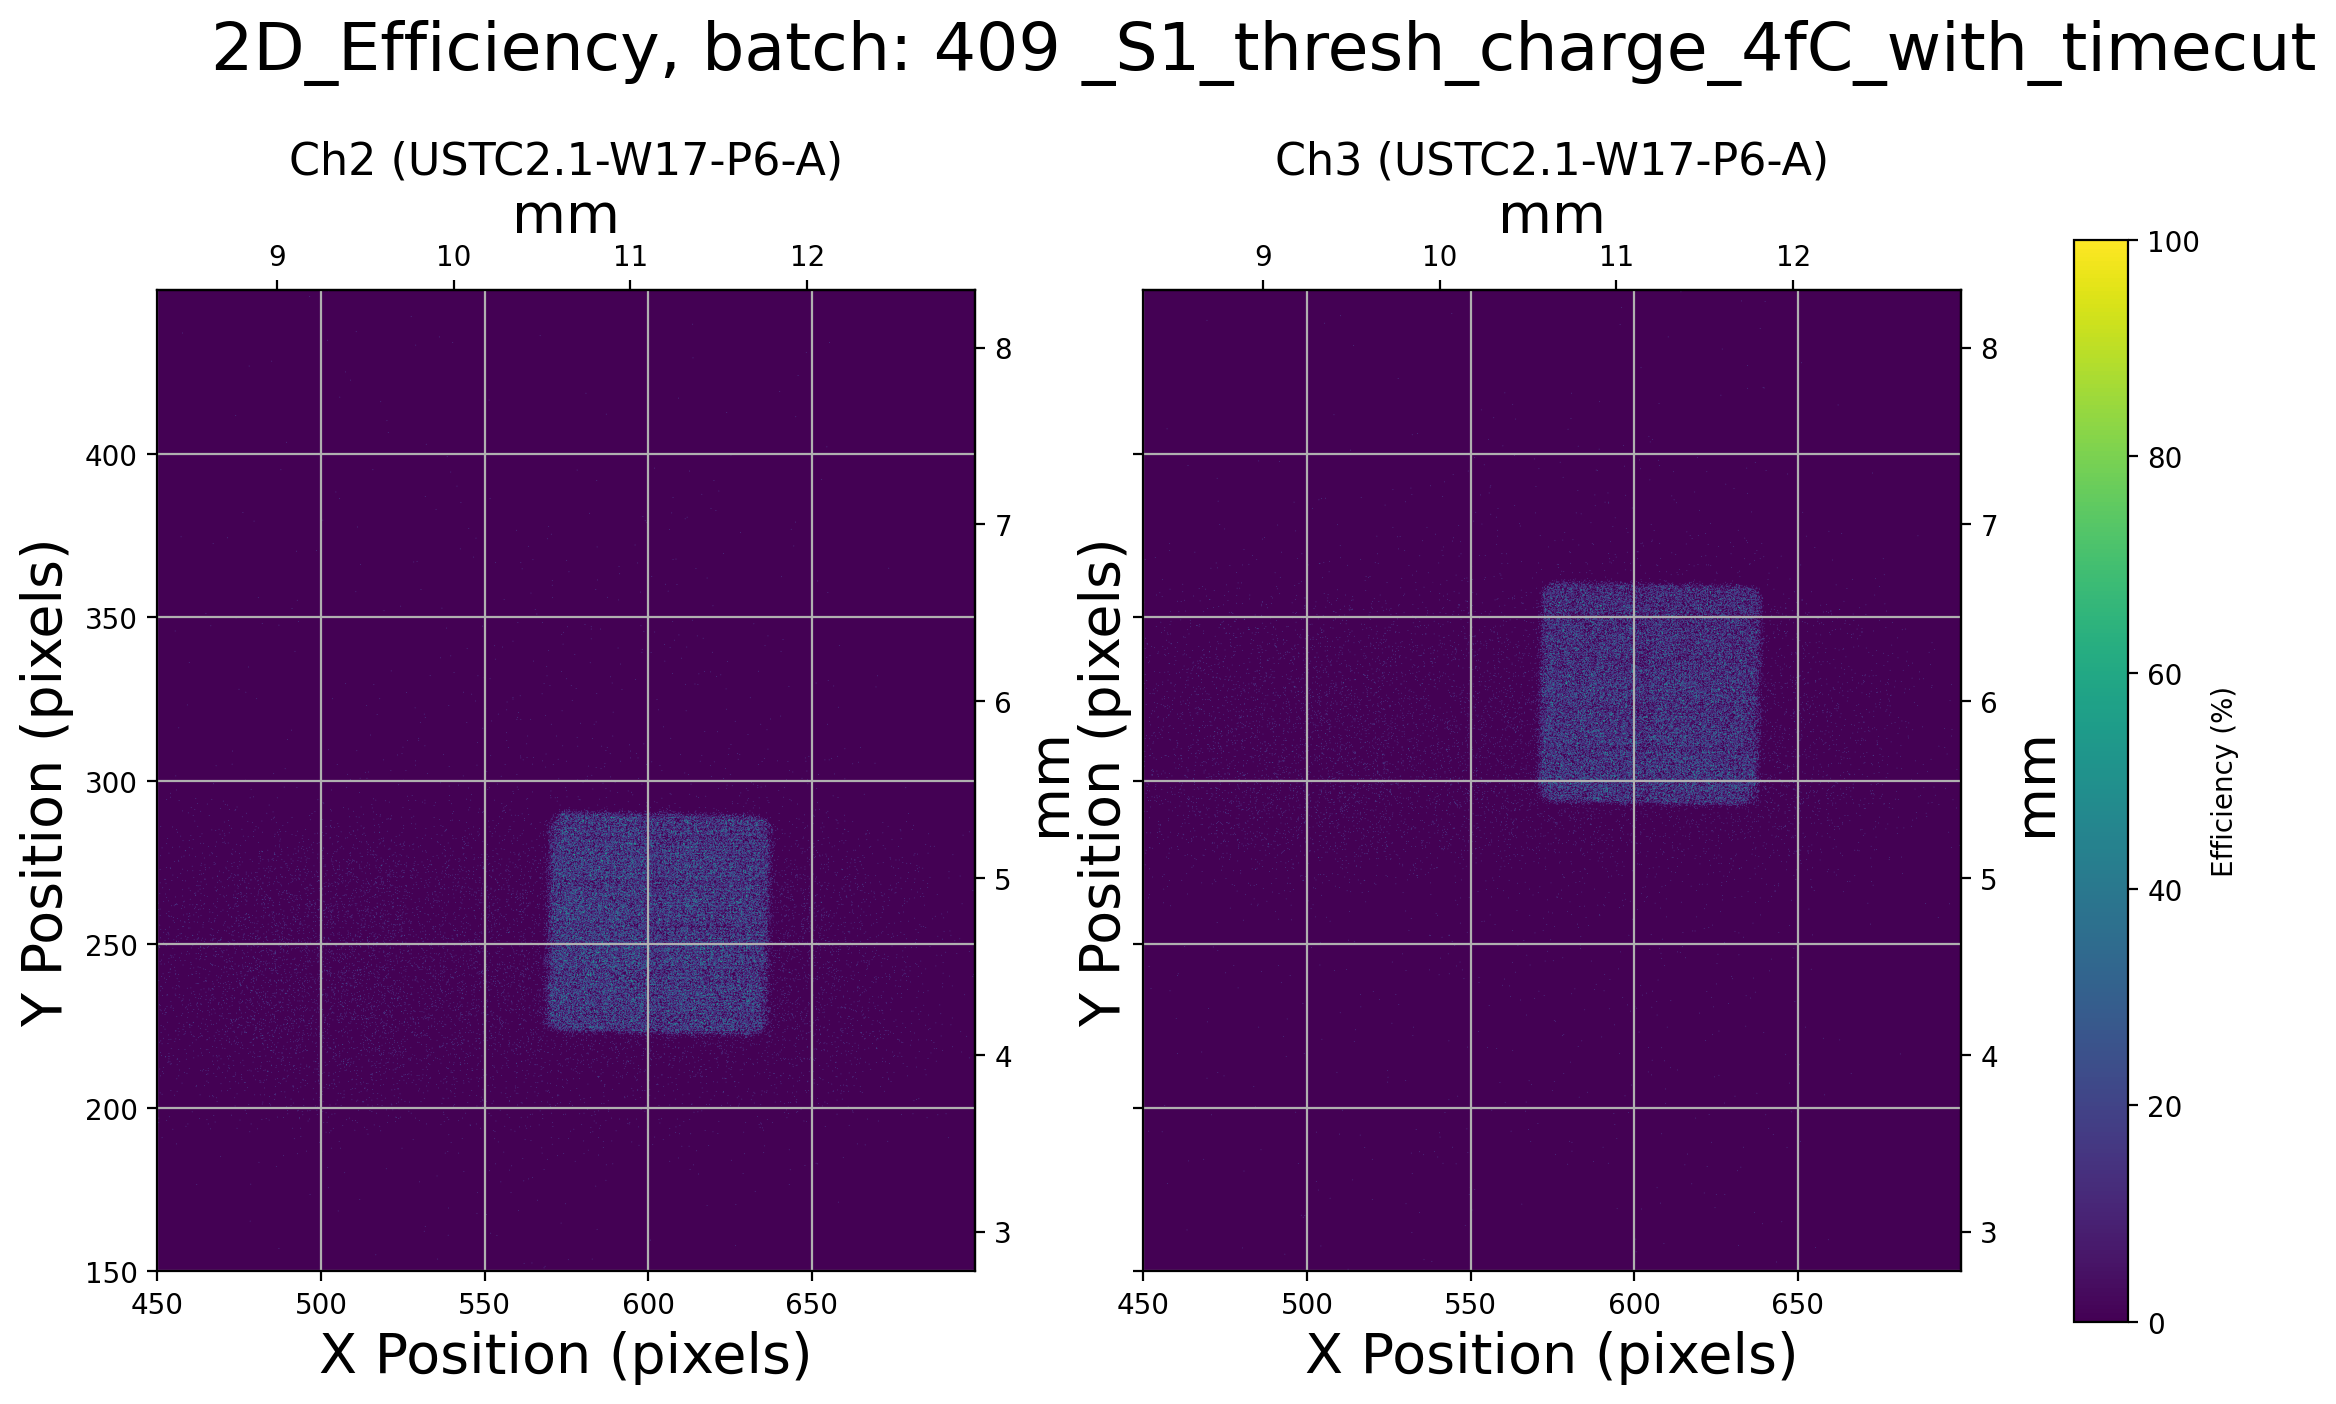

In [26]:
# %matplotlib inline
SAVE = True
for this_batch,S in batches_to_study:
    df = load_batch(this_batch,S)
    binning_method = 'rice'
    save_path = '../various plots/USTC_room_temp/'
#     os.mkdir(save_path)
    time_cut = [time_mask(df, i, plot=False)[0] for i in DUTs]
    transimpedance = get_transimpedance(this_batch,S) ### this is still easier than extracting all the single values
    threshold_charge = 4 #fC
    #     print(f'angle: {dict_of_batches[this_batch].angle}°', f'temperature:{dict_of_batches[this_batch].tempA}°C')
    plot(df, "2D_Sensors", this_batch, sensors=sensors_list[this_batch][S], bins=bins1, bins_find_min=binning_method,
         n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}', fmt='jpg')
    
    plot(df, "1D_Efficiency", batch=this_batch, sensors=sensors_list[this_batch][S], transimpedance=transimpedance, threshold_charge=threshold_charge, geometry_cut=True,
                    bins=bins1, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}_threshold_charge_{threshold_charge}fC')
    
    plot(df, "1D_Efficiency", batch=this_batch, sensors=sensors_list[this_batch][S], transimpedance=transimpedance, threshold_charge=threshold_charge, geometry_cut=True, mask=time_cut,
                    bins=bins1, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}_threshold_charge_{threshold_charge}fC_with_timecut')
#     plt.show()
    plot(df, "2D_Efficiency", batch=this_batch, sensors=sensors_list[this_batch][S], transimpedance=transimpedance, threshold_charge=threshold_charge, geometry_cut=False,
                    bins=bins1, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}_thresh_charge_{threshold_charge}fC')
    
    plot(df, "2D_Efficiency", batch=this_batch, sensors=sensors_list[this_batch][S], transimpedance=transimpedance, threshold_charge=threshold_charge, geometry_cut=False, mask=time_cut,
                    bins=bins1, bins_find_min=binning_method, n_DUT=DUTs, savefig=SAVE, savefig_path=save_path, savefig_details=f'_{S}_thresh_charge_{threshold_charge}fC_with_timecut')


In [27]:
# _,my_bins,_,fig,ax = plot_histogram(df['pulseHeight_1'],bins='rice')
# plot_histogram(df['pulseHeight_1'].loc[df['charge_1']>4], bins=my_bins, fig_ax=(fig,ax))
# plot_histogram(df['pulseHeight_1'].loc[time_cuts[0]], bins=my_bins, fig_ax=(fig,ax))
# ax.semilogy()

[WARNING] -	 in time_mask() plot has been closed
[WARNING] -	 in time_mask() plot has been closed
[WARNING] -	 in time_mask() plot has been closed
[WARNING] -	 in time_mask() plot has been closed


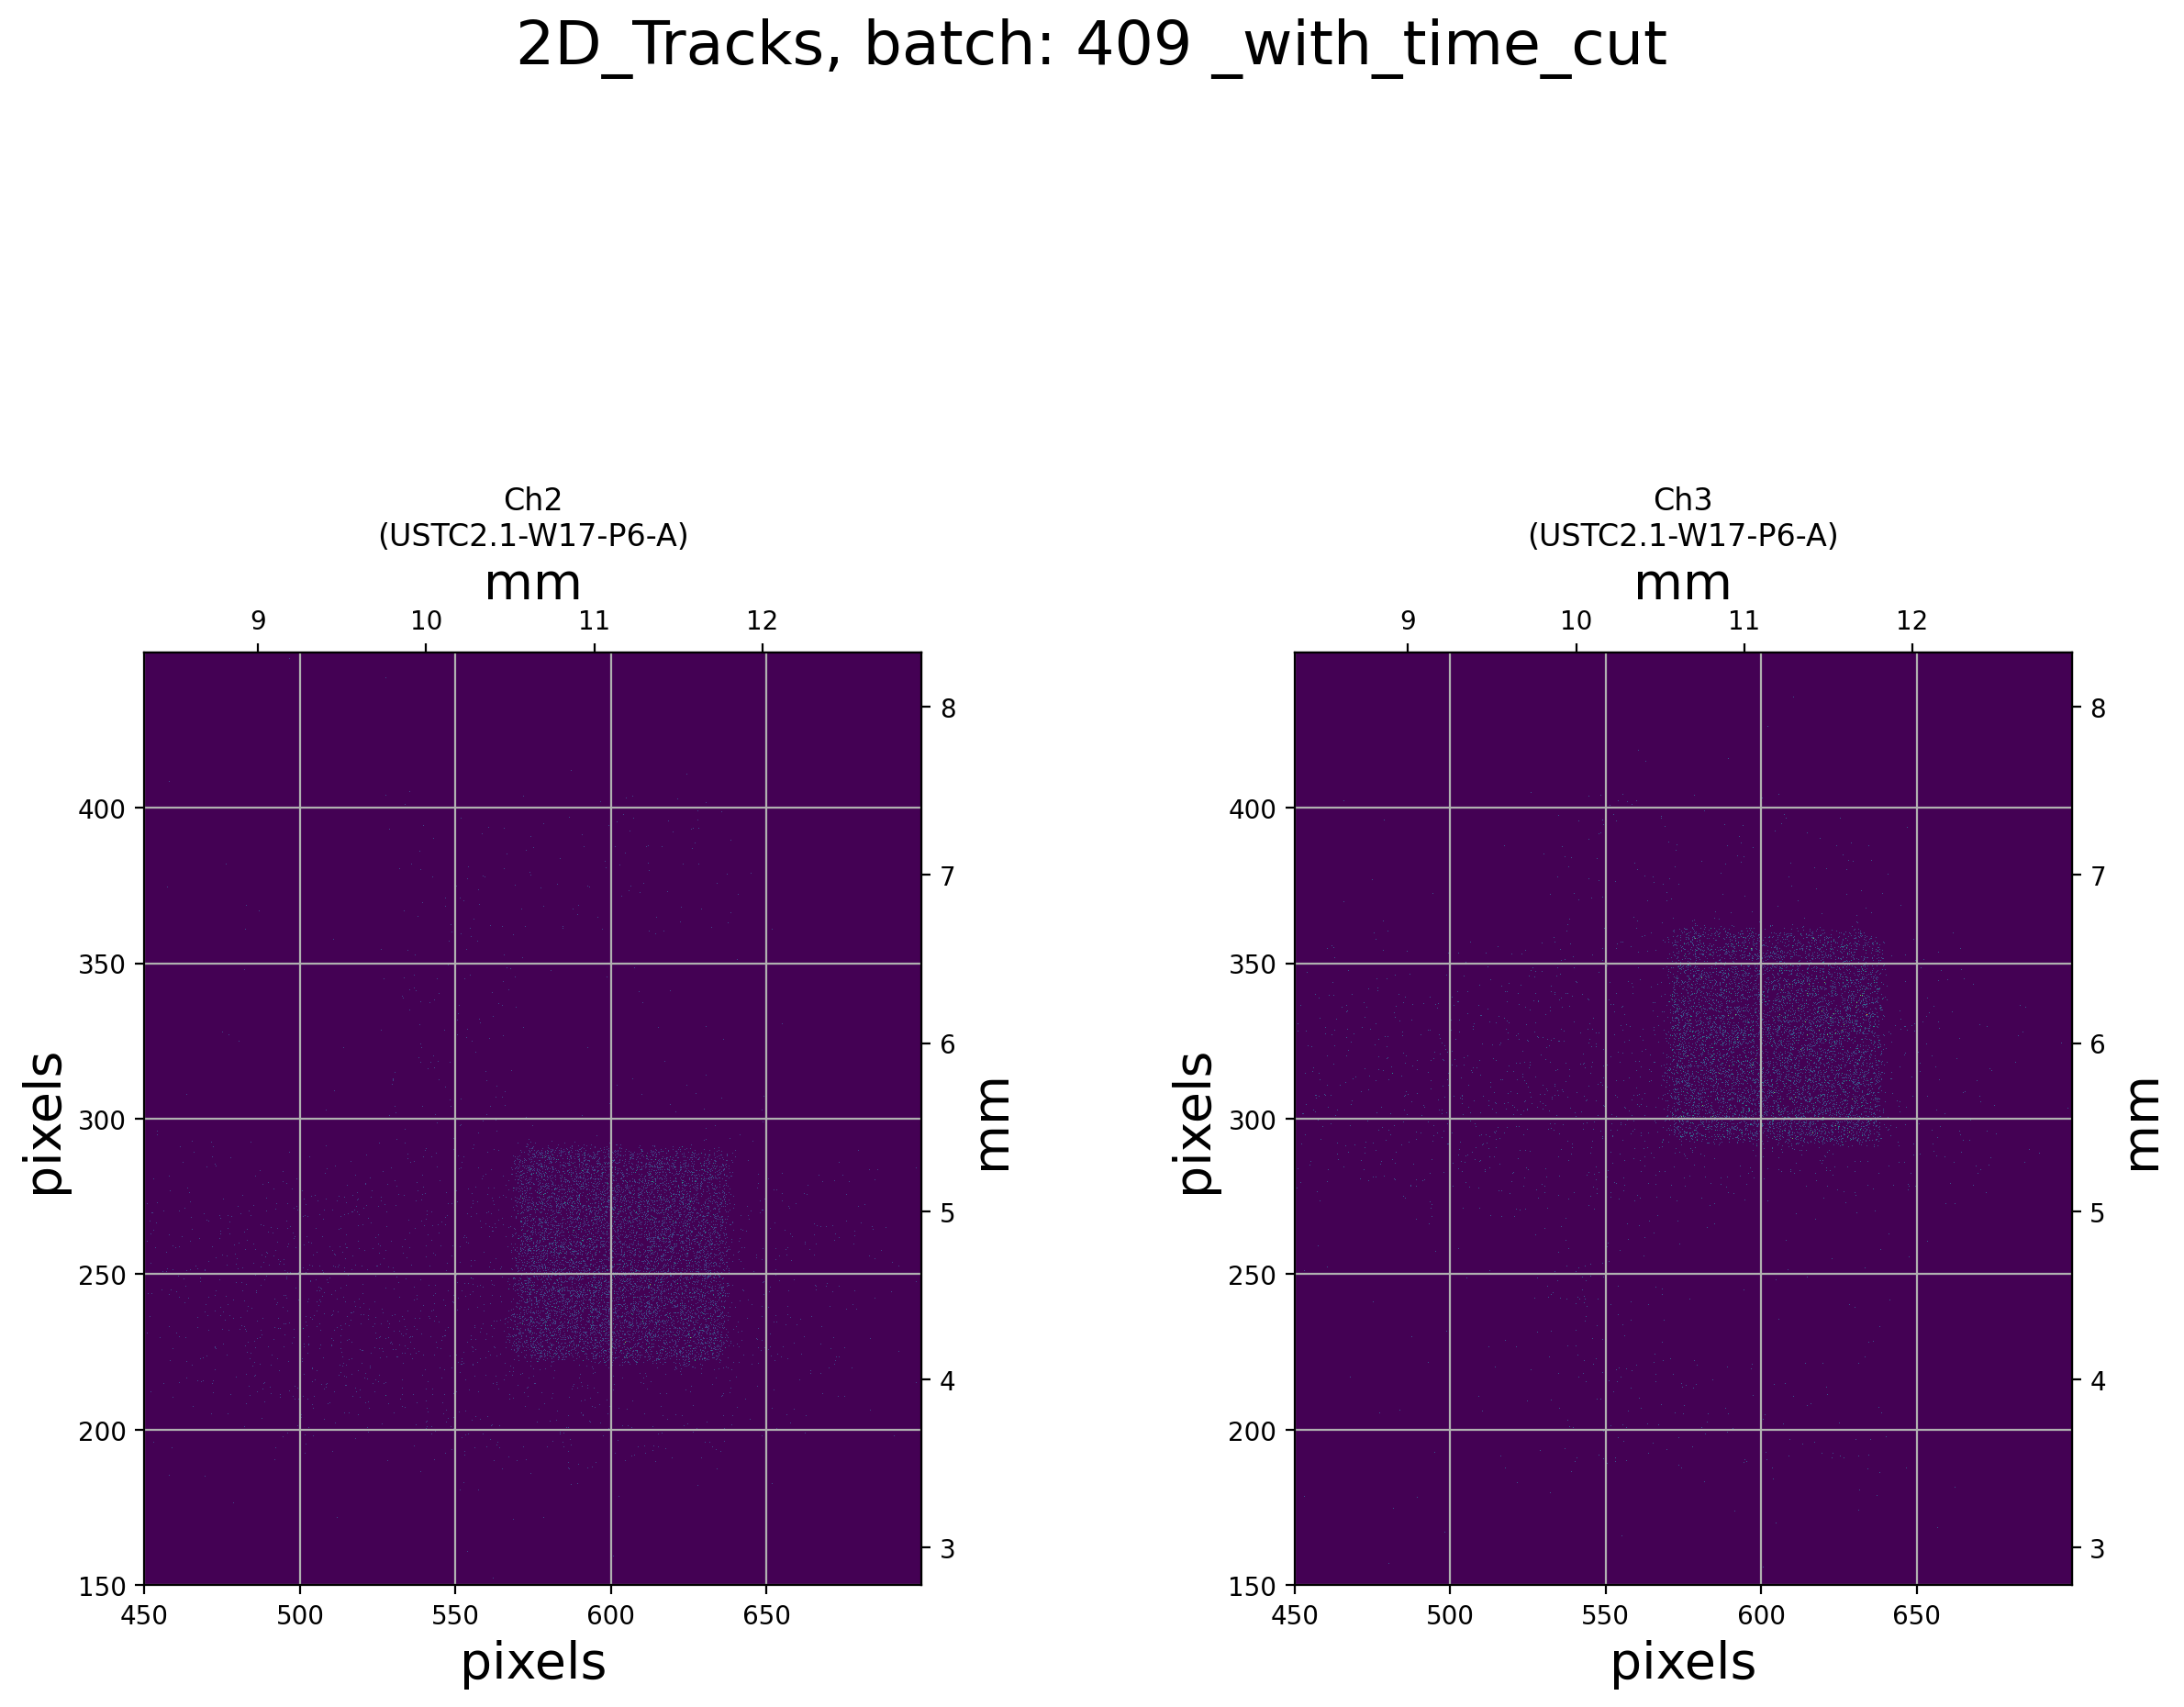

(<Figure size 2400x2000 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Ch2\n(USTC2.1-W17-P6-A)'}, xlabel='pixels', ylabel='pixels'>,
        <AxesSubplot:title={'center':'Ch3\n(USTC2.1-W17-P6-A)'}, xlabel='pixels', ylabel='pixels'>],
       dtype=object))

In [28]:
time_cuts = [time_mask(df, dut, bins=5000, plot=False)[0] for dut in (1,2)]
other_info = [time_mask(df, dut, bins=5000, plot=False)[1] for dut in (1,2)]
# time_cuts.insert(0,None)
plot(df, "2D_Tracks", this_batch, bins=bins1, sensors=sensors_list[this_batch][S], n_DUT=[1,2], mask=time_cuts,
    savefig=True, savefig_details='_with_time_cut',fmt='jpg')

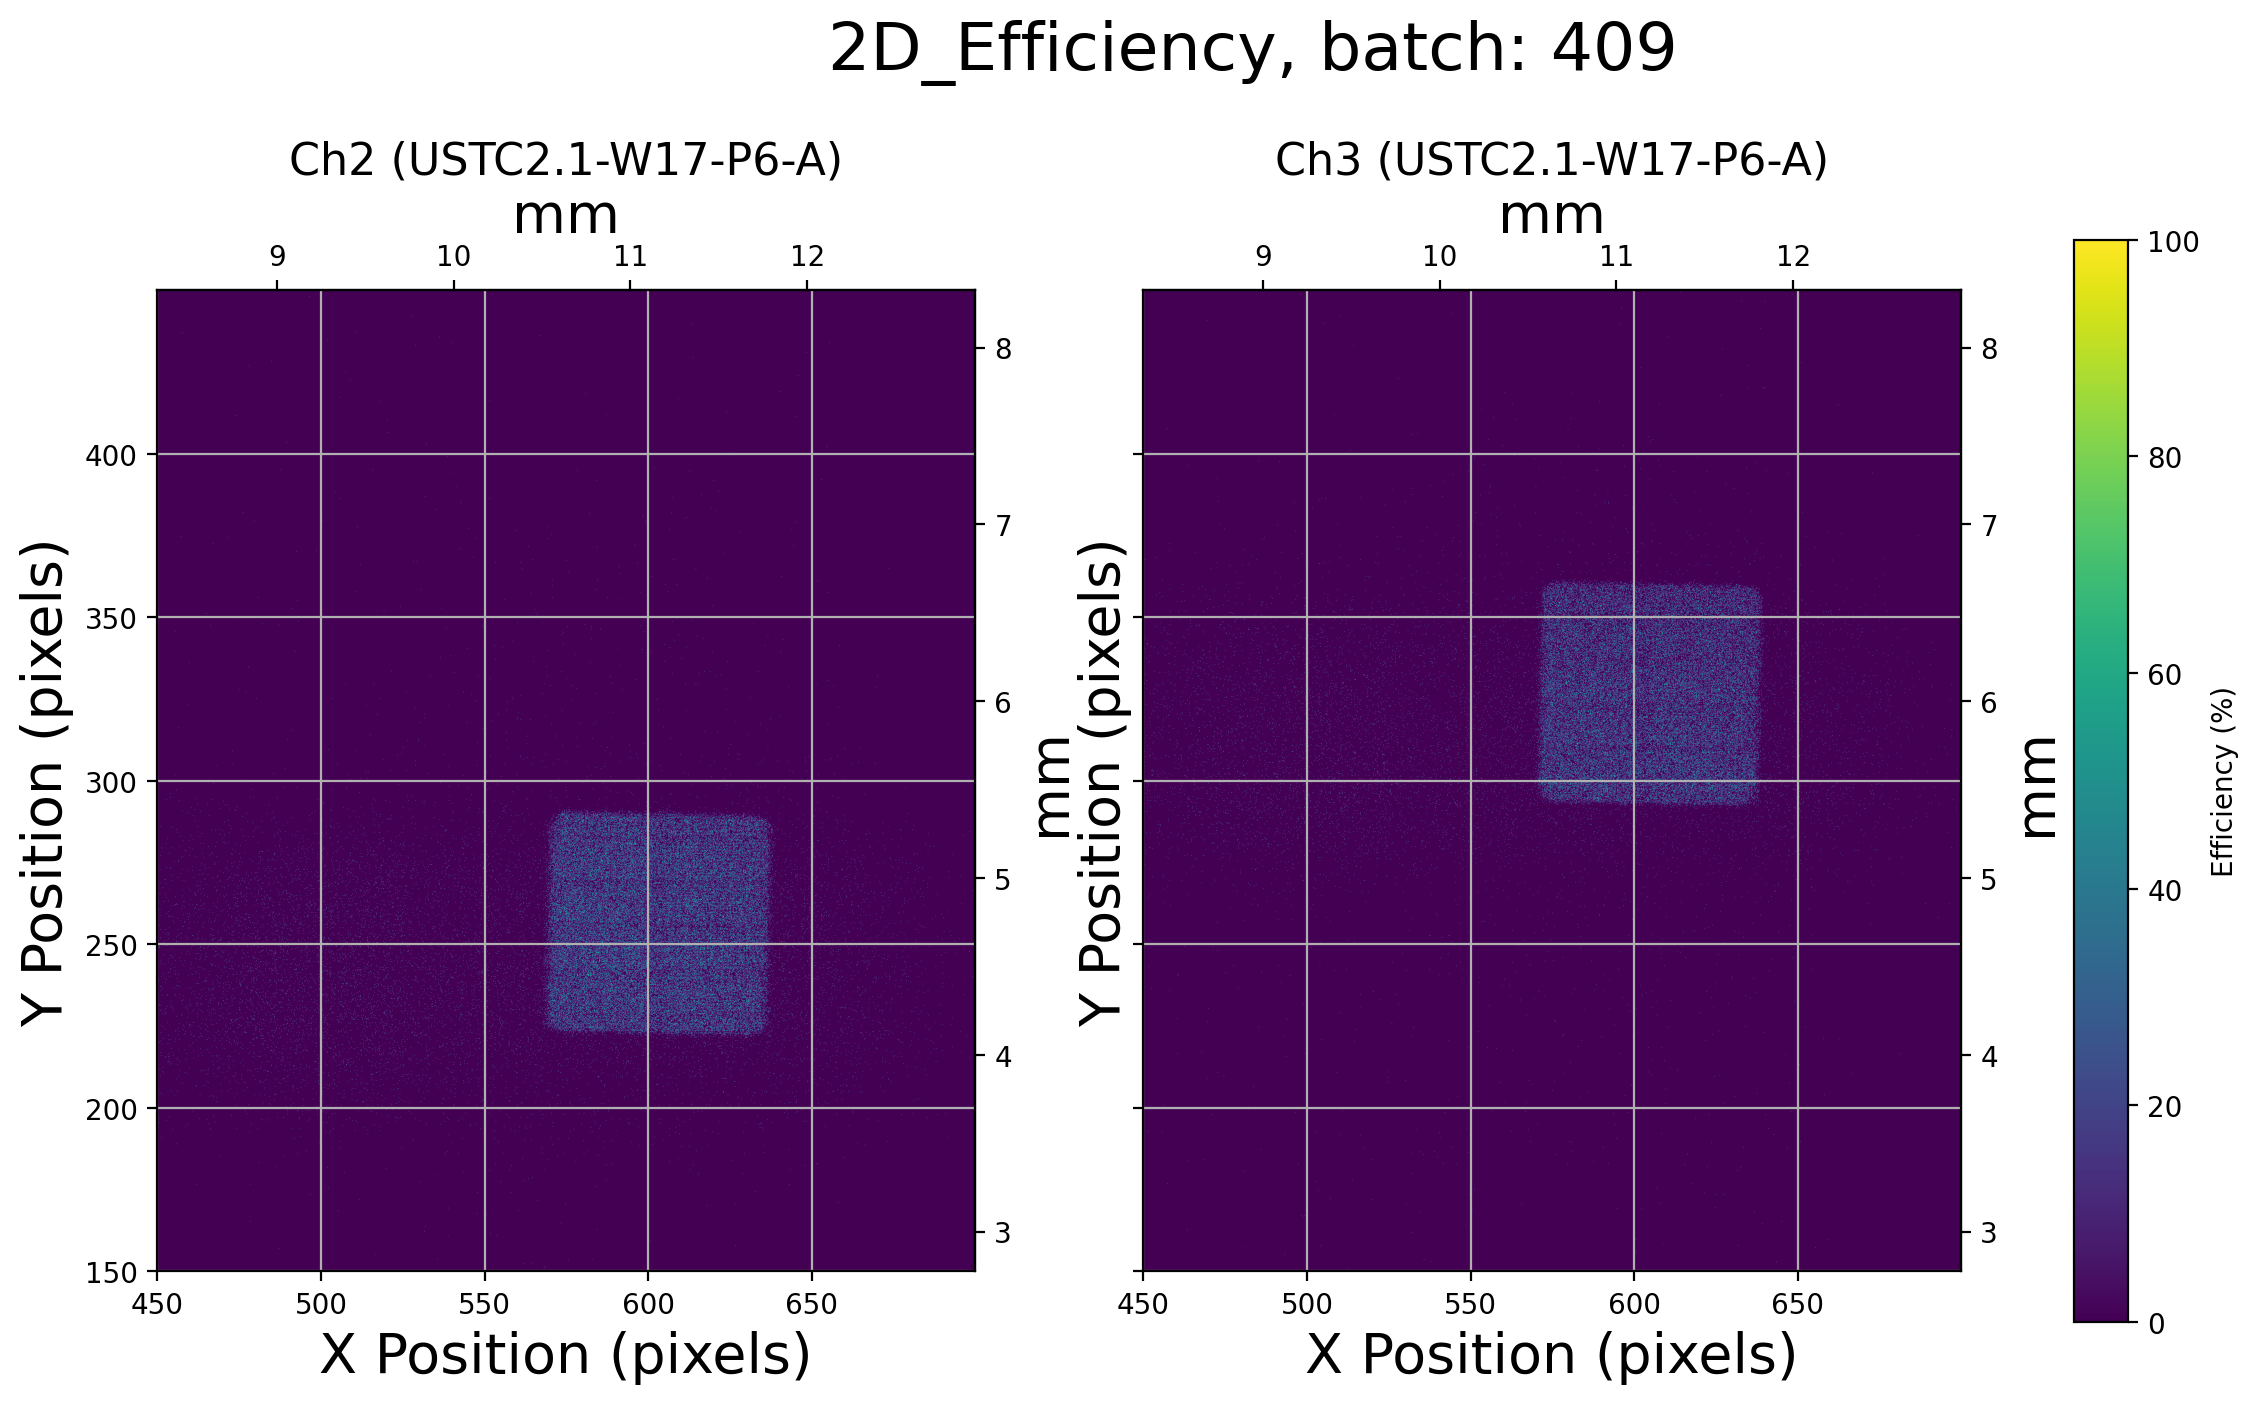

(<Figure size 2400x1200 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Ch2 (USTC2.1-W17-P6-A)'}, xlabel='X Position (pixels)', ylabel='Y Position (pixels)'>,
        <AxesSubplot:title={'center':'Ch3 (USTC2.1-W17-P6-A)'}, xlabel='X Position (pixels)', ylabel='Y Position (pixels)'>],
       dtype=object))

In [29]:
plot(df, "2D_Efficiency", this_batch, bins=bins1, sensors=sensors_list[this_batch][S], n_DUT=[1,2], mask=time_cuts,
    transimpedance=get_transimpedance(this_batch,S), threshold_charge=4)

[WARNING] -	 in find_min_btw_peaks(), closing plots
[WARNING] -	 in find_min_btw_peaks(), closing plots


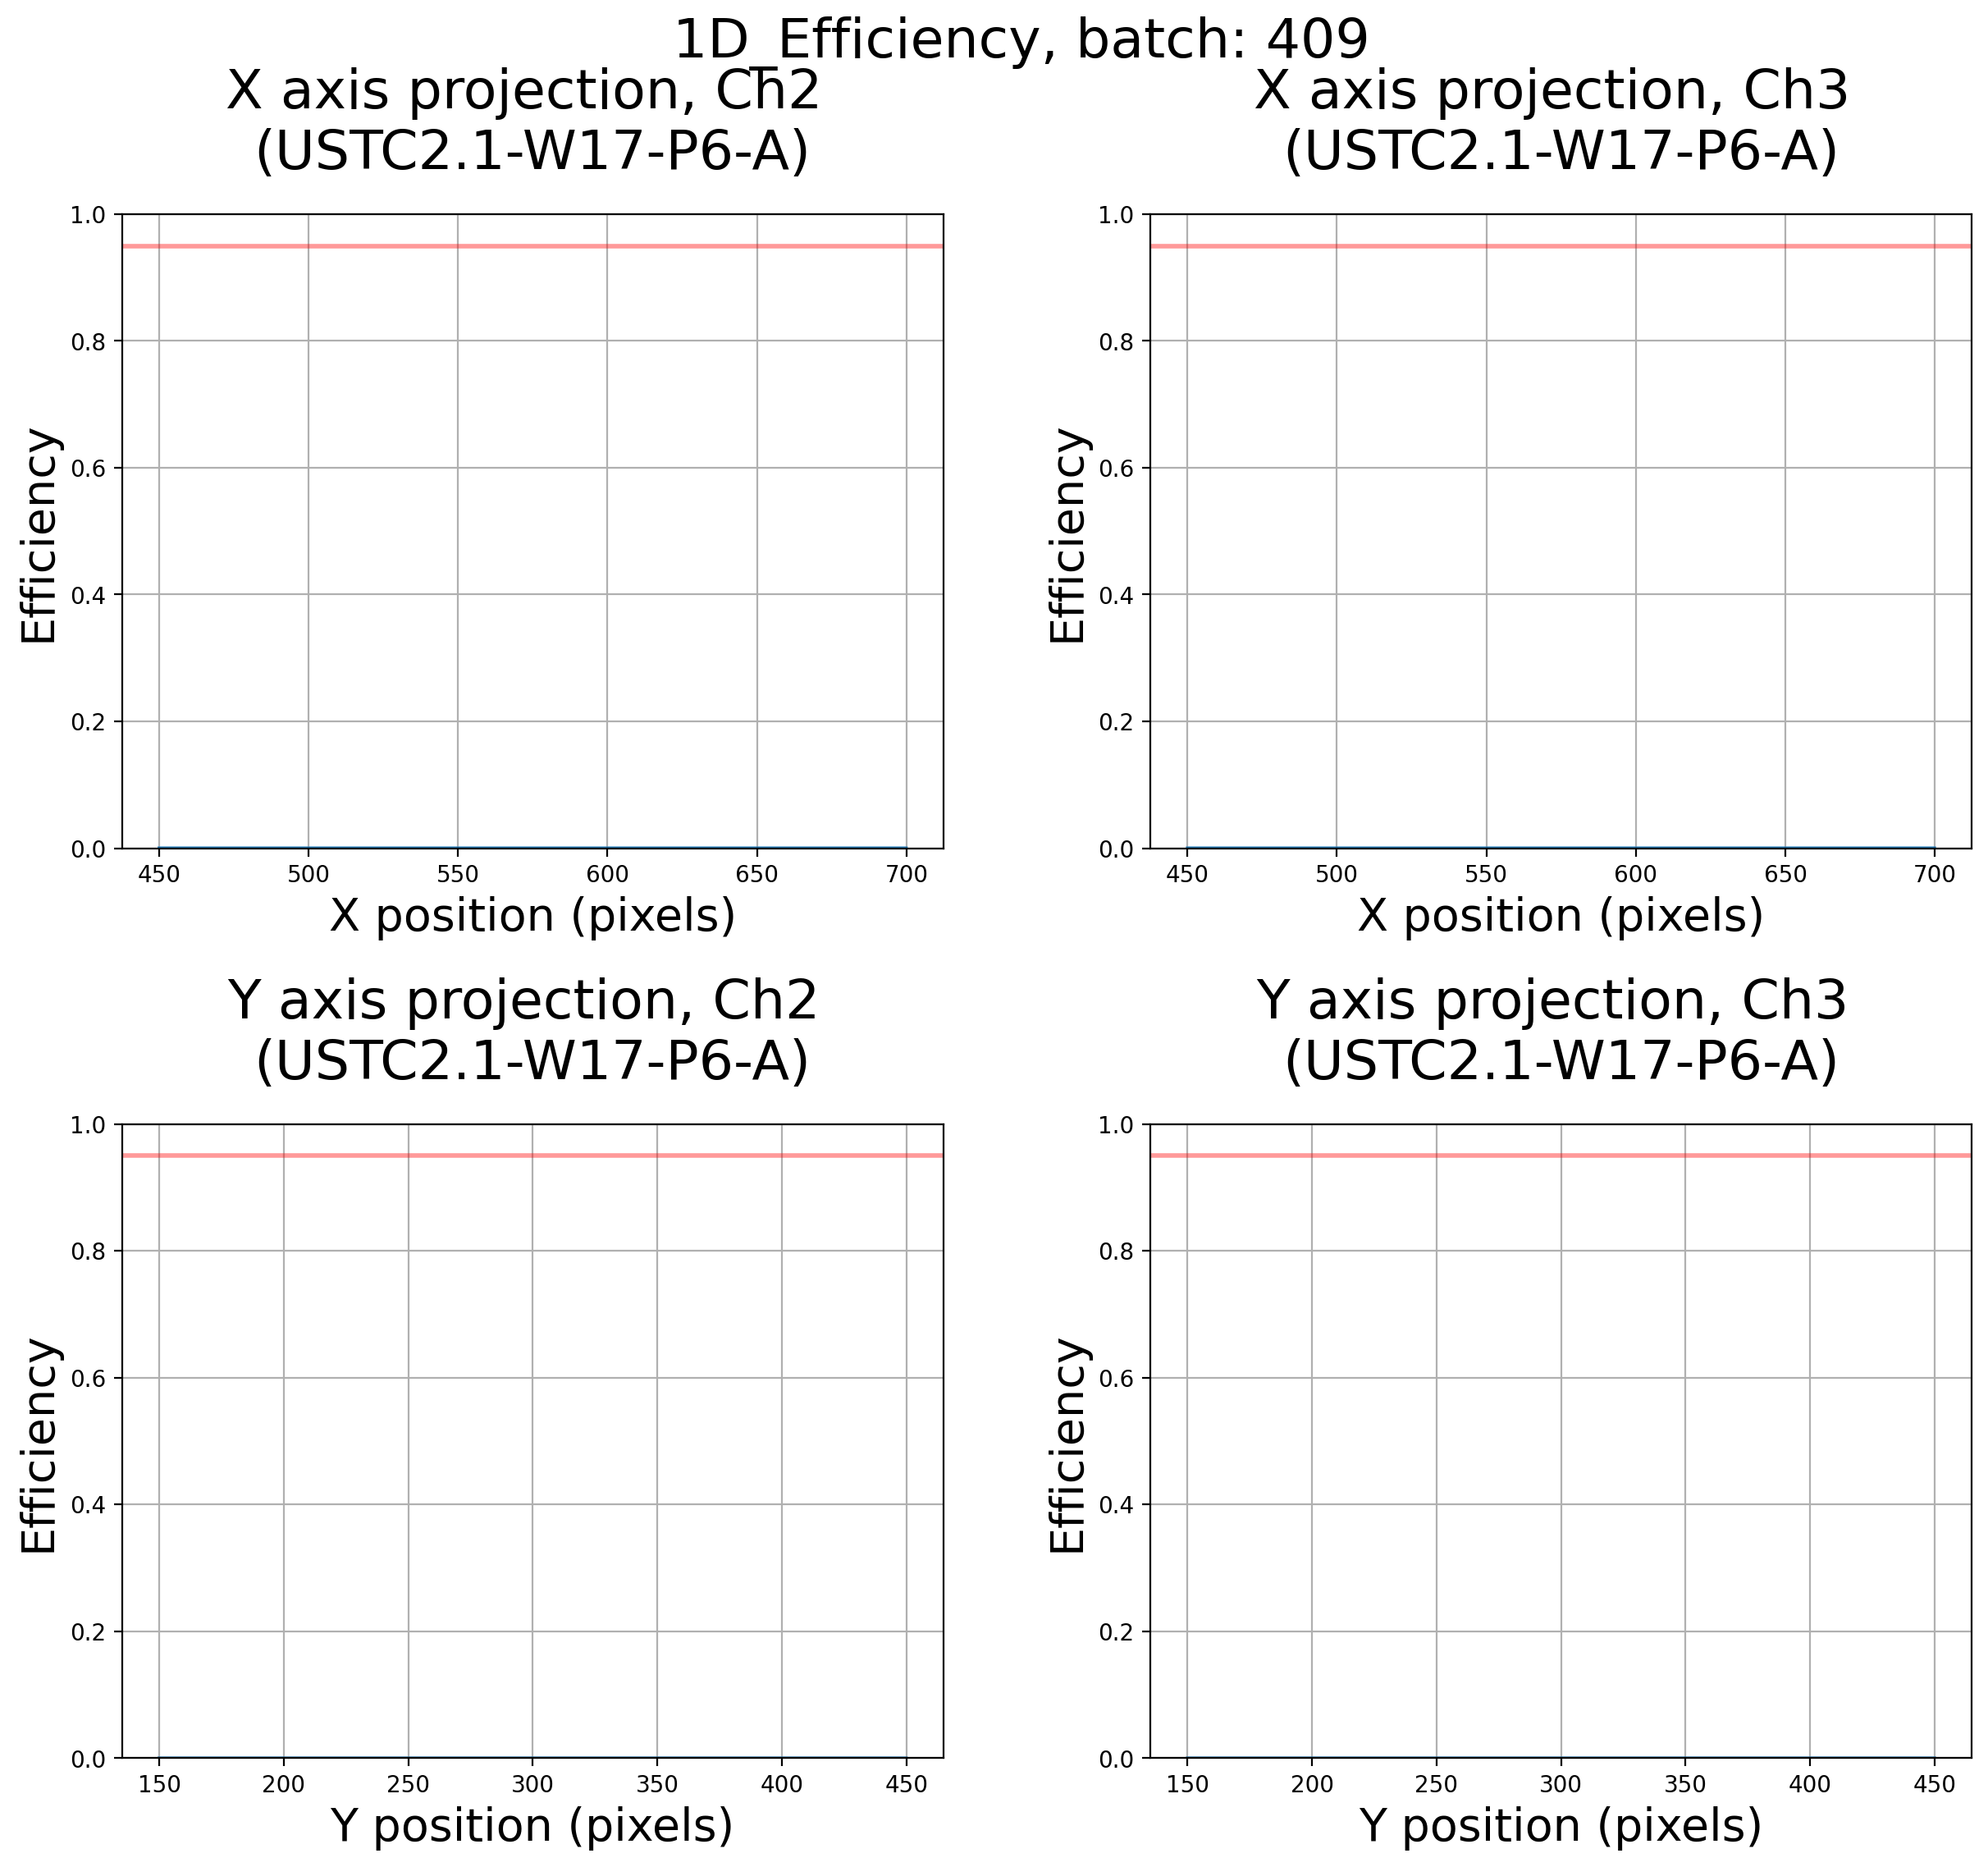

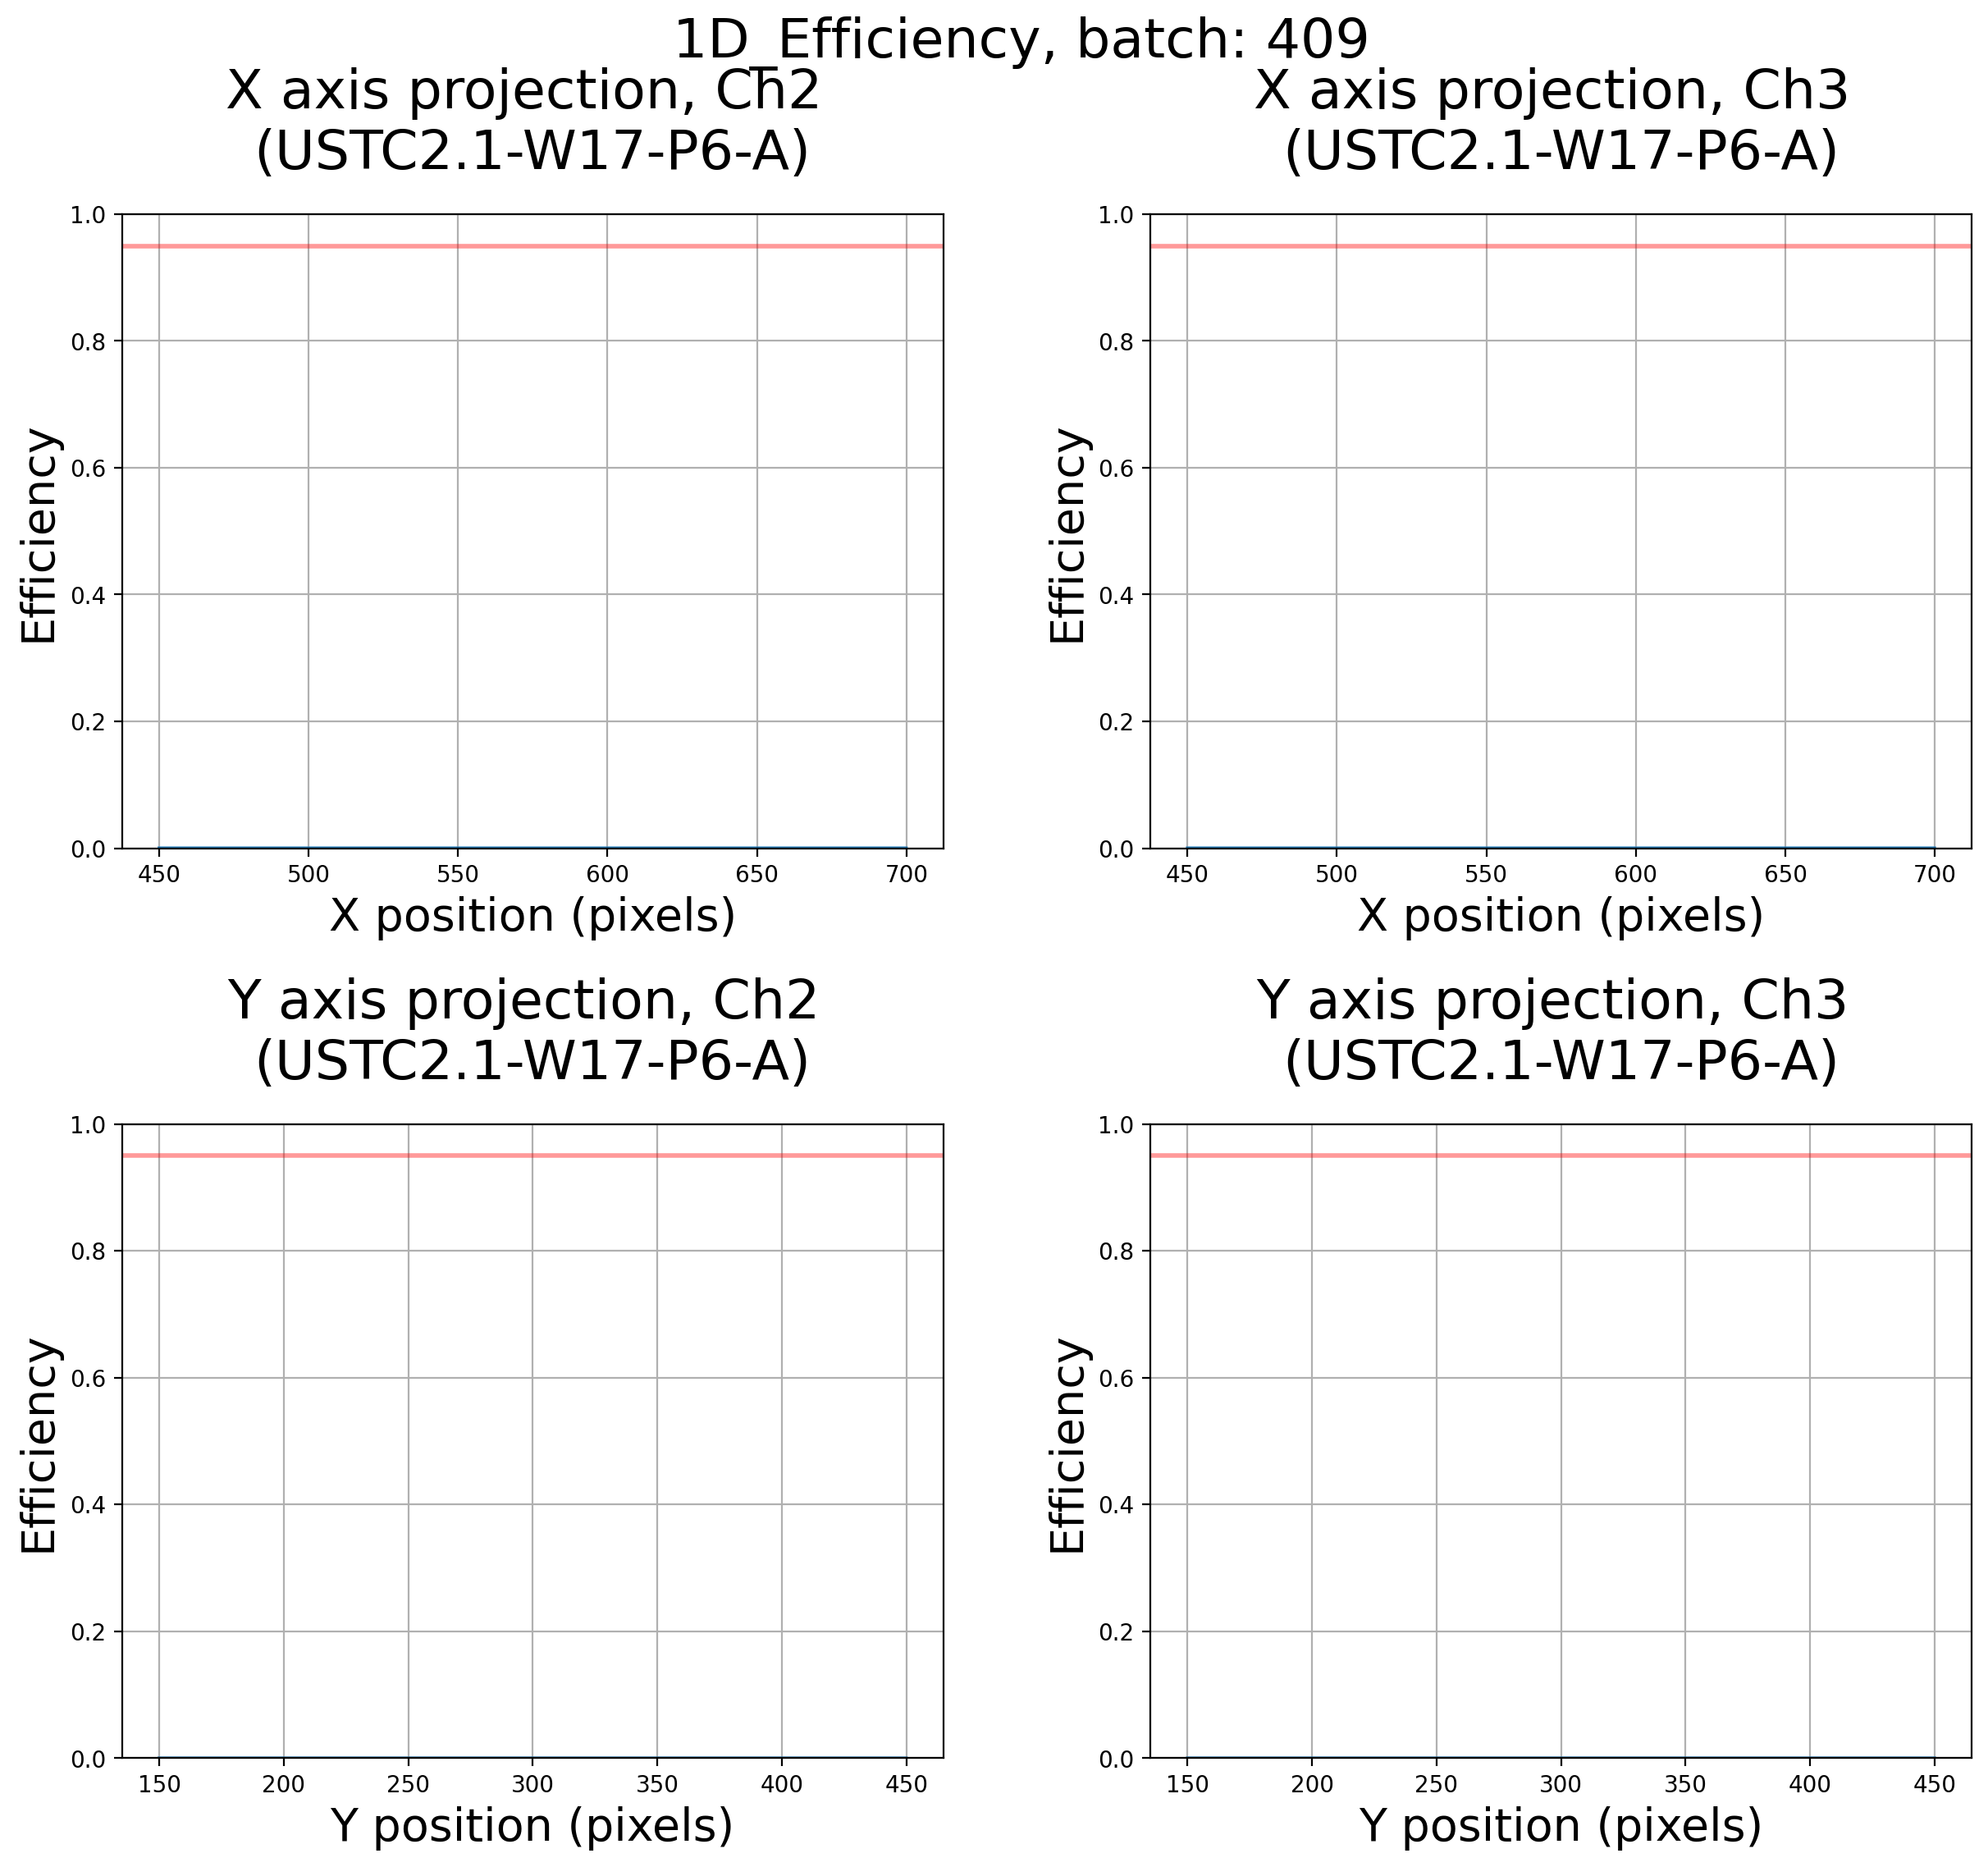

In [30]:
fig,ax = plot(df, "1D_Efficiency", this_batch, bins=bins1, sensors=sensors_list[this_batch][S], n_DUT=[1,2], mask=time_cuts, geometry_cut=True,
    transimpedance=get_transimpedance(this_batch,S), threshold_charge=4)
fig

In [ ]:
print('Angled')
for batch_number,S,ch in USTC_dict['angled']:
    print('Batch', batch_number, 'MCP voltage:', dict_of_batches[batch_number].S[S].channels['Ch1'].voltage)
    print('sensor angle:',dict_of_batches[batch_number].angle)
    df = load_batch(batch_number, this_scope)
    